# 0: Load Modulues, define functions and setup script configuration variables

## 0.0: Load modules

In [5]:
import sys, os
# insert the parent folder of `notebooks/` as the first place to look for modules
sys.path.insert(0, os.path.abspath('..'))

from pathlib import Path
import subprocess, pathlib, textwrap
from pathlib import Path
import time

# import custom definitions
from pys.utils.ml_utilities import *

from pprint import pprint

import numpy as np
import pandas as pd
import polars as pl, pyarrow # required for polars file reading

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
from plotly.subplots import make_subplots



from scipy import stats
from scipy.stats import skew, boxcox


import warnings
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

start_time_all = time.time()

## 0.2: Define Definitions - moved to pys.utils.ml_utilities

## 0.3: Setup Cofigs for the Script
1. setup working directories
2. configs


In [6]:

ROOT = Path.cwd().resolve()  # assumes notebook is run from repo root or subdir
if ROOT.name == 'notebooks':
    ROOT = ROOT.parent  # go up one level if in notebooks directory


DATA_DIR = ROOT / 'data'
DATA_DIR.mkdir(parents=True, exist_ok=True)

DATA_RAW = DATA_DIR / 'raw'
DATA_RAW.mkdir(parents=True, exist_ok=True)


RESULTS_DIR = ROOT / 'results'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f'Download directory: {DATA_RAW}')

# Configuration for data processing
# Set decimal places for data in df_models 
round_to = 3

## Set global display and figure parameters
# set display format to be decimal vs scientific
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# set the plot size using 'rcPrams'
plt.rcParams['figure.figsize'] = [15, 10]

Download directory: /Users/brianr/repos/UCBAIML-GDSC-Dev/data/raw


## 0.4: Track information regarding dropped rows and features and bounds

In [7]:
# Track dropped items
# dict_dropped_rows = {} # capture the number of items dropped through the EDA process
dict_features = {} # Capture information about features

# # track calcualted bounds for each numeric  feature analyzed
# df_bounds = pd.DataFrame(columns=['feature', 'lower', 'upper', 'q1', 'q3', 'iqr'])

# #  Initialize results DataFrame
# df_models = pd.DataFrame(columns=[
#     'Model',  'Dataset', 'Train_Time', 'Accuracy',
#     'Precision', 'Recall', 'FBeta', 'PR_AUC'
# ])

# 1: Load data sets

## Load data form files

In [8]:
## Load data files

## import drug compound data 
drug_df = pd.read_csv(DATA_RAW / "screened_compounds_rel_8.5.csv")
print("Compund matrix drug_df ", drug_df.shape)

# ==== import cell line information ----
cell_df =  pd.read_excel(DATA_RAW / "Cell_Lines_Details.xlsx") 
cell_df = cell_df.rename(columns={'COSMIC identifier': 'COSMIC_ID'})
cell_df = cell_df.dropna(subset=['COSMIC_ID'])
cell_df['COSMIC_ID'] = cell_df['COSMIC_ID'].astype(int)
print("Cell matrix cell_df ", cell_df.shape)


# ---- import drug response ----
dose_df = pd.read_excel(DATA_RAW / "GDSC2_fitted_dose_response_27Oct23.xlsx")
print("Drug-response matrix dose_df:", dose_df.shape)


# ---- import raw methylation (needs transformation to be useable) ----
meth_df = read_parque_to_pd_df(DATA_RAW / "methylation/meth_df_cosmic_ids.parquet")
print("Methylation matrix meth_df:", meth_df.shape)

# ---- import mutations ----
mut_df = pd.read_excel(DATA_RAW  / "variants/WES_variants.xlsx",  sheet_name='WES_variants')
print("Mutation matrix mut_df:", mut_df.shape)


# ---- import expression (as temporary raw) ----
expr_raw = pd.read_csv(
    DATA_RAW  / "gene_expression/sanger1018_brainarray_ensemblgene_rma.txt.gz",
    sep="\t", index_col=0)
print("Expression matrix expr_df:", expr_raw.shape)


Compund matrix drug_df  (621, 6)
Cell matrix cell_df  (1001, 13)
Drug-response matrix dose_df: (242036, 19)
Methylation matrix meth_df: (962, 485515)
Mutation matrix mut_df: (486243, 13)
Expression matrix expr_df: (17737, 1018)


# 2: Condition dataframes into common formatted colomn names

Cleanup up format of column names:
- remove \n and spaces
- shorten names
- make lower case

## 2.1: Clean up column names

In [9]:
# rename drug_df columns
#display(drug_df.columns.to_list())

#make column names lower and add remplace spaces
drug_df.columns = (
    drug_df.columns
        .str.lower()
        .str.replace(r"[ \t]+", "_", regex=True)   # drop spaces and tabs
)
# Reorder
drug_df = drug_df[['drug_id',
                'drug_name',
                'synonyms',
                'target',
                'target_pathway',
                'screening_site']]

#display(drug_df.columns.to_list())

In [10]:
# rename and reorder cell_df
# display(cell_df.columns.to_list())

rename_cell_cols = {'Sample Name': 'cell_line',
                    #'COMSIC_ID': 'comsic_id',
                   'Whole Exome Sequencing (WES)': 'wes',
                   'Copy Number Alterations (CNA)': 'cna',
                    'Gene Expression': 'gene_expression',
                    'Methylation': 'methylation',
                    'Drug\nResponse': 'drug_response',
                    'GDSC\nTissue descriptor 1': 'tissue_desc_1',
                    'GDSC\nTissue\ndescriptor 2': 'tissue_desc_2',
                    'Cancer Type\n(matching TCGA label)': 'cancer_type',
                    'Microsatellite \ninstability Status (MSI)': 'msi',
                    'Screen Medium': 'screen_medium',
                    'Growth Properties': 'growth_properties' 
                    }
cell_df = cell_df.rename(columns=rename_cell_cols)

# reorder columns
# order = ['COSMIC_ID','cell_id',
#  'wes',
#  'cna',
#  'gene_expression',
#  'methylation',
#  'drug_response',
#  'tissue_desc_1',
#  'tissue_desc_2',
#  'cancer_type',
#  'msi',
#  'screen_medium',
#  'growth_properties']
#cell_df = cell_df[order]

# put 'COSMIC_ID' as first column
cell_df = cell_df.set_index("COSMIC_ID").reset_index()


display(cell_df.columns.to_list())

['COSMIC_ID',
 'cell_line',
 'wes',
 'cna',
 'gene_expression',
 'methylation',
 'drug_response',
 'tissue_desc_1',
 'tissue_desc_2',
 'cancer_type',
 'msi',
 'screen_medium',
 'growth_properties']

In [11]:
# setup dose_df

# make column names lower and add remplace spaces
dose_df.columns = (
    dose_df.columns
        .str.lower()
        .str.replace(r"[ \t]+", "_", regex=True)   # drop spaces and tabs
)
dose_df = dose_df.rename(columns={'cosmic_id': 'COSMIC_ID',
                                  'tcga_desc':  'cancer_type_tcga',
                                  'cell_line_name': 'cell_line',
                                  'putative_target': 'target',
                                  'min_conc': 'min',
                                  'max_conc': 'max',
                                  'pathway_name': 'pathway'
                                  })


# put 'COSMIC_ID' as first column
dose_df = dose_df.set_index('COSMIC_ID').reset_index()

display(dose_df.columns.to_list())


['COSMIC_ID',
 'dataset',
 'nlme_result_id',
 'nlme_curve_id',
 'cell_line',
 'sanger_model_id',
 'cancer_type_tcga',
 'drug_id',
 'drug_name',
 'target',
 'pathway',
 'company_id',
 'webrelease',
 'min',
 'max',
 'ln_ic50',
 'auc',
 'rmse',
 'z_score']

In [12]:
# rename and reorder mut_df
# display(mut_df.columns.to_list())

# make column names lower and add remplace spaces
mut_df.columns = (
    mut_df.columns
        .str.lower()
        .str.replace(r"[ \t]+", "_", regex=True)   # drop spaces and tabs
)
# df.columns = (
#     df.columns
#       .str.lower()                    # everything to lower-case
#       .str.replace(r"[ \t]+", "", regex=True)   # drop spaces and tabs
# )

mut_df = mut_df.rename(columns={'cosmic_id':'COSMIC_ID',
                                'sample':'cell_line'
                                })

# put 'COSMIC_ID' as first column
mut_df = mut_df.set_index("COSMIC_ID").reset_index()


display(mut_df.columns.to_list())


['COSMIC_ID',
 'cell_line',
 'cancer_type',
 'gene',
 'transcript',
 'cdna',
 'aa',
 'classification',
 'gene_list',
 'recurrence_filter',
 'subs',
 'truncating',
 'inframe']

## 2.2: Get a set of common cell lines (cosmic_id) and drug names/ids across all data sets
Get a unified data set with cell lines in common
Reduce data sets to the common cell lines based on COMSIC_ID

###  For Expression data: Compress replicates of COSMIC_ID.# for each cell line to a single row
Some cell lines were sampled more than once, hence the .1 at the end of the COSMIC_ID
For those samples, get the mean output of the entries (rows) for each cell line and remove the .1 from the column name

In [13]:
# Add COSMIC_ID to expression data
print("Expression data (expr_df): Compress column header (COSMIC_ID) to single entry per cell line (via mean of entries):")

def to_single_cosmic_id(col_index):
    """Return Series[int] of COSMIC_IDs for an Index/array-like."""
    return (
        col_index.astype(str)
                 .str.split('.', n=1).str[0]   # keep part before first dot
                 .astype(int)                  # safe now
    )

# Map columns → COSMIC_ID
cosmic_idx = to_single_cosmic_id(expr_raw.columns)
expr_raw.columns = cosmic_idx

# Collapse technical replicates by column-mean
expr_df = expr_raw.groupby(expr_raw.columns, axis=1).mean().reset_index()
expr_df = expr_df.set_index('ensembl_gene')
# del expr_raw
print("Expression matrix:", expr_df.shape, "genes by cell-lines")   # genes × unique cell‐lines


Expression data (expr_df): Compress column header (COSMIC_ID) to single entry per cell line (via mean of entries):
Expression matrix: (17737, 1014) genes by cell-lines


In [14]:
# ---- intersection check ----
def standardize_ids_to_int(col):
    """standardise COSMIC and DRUG IDs across files"""
    return col.astype(str).str.replace(r"[A-Z_]", "", regex=True).astype(int)

# overwrite the original column with the int IDs
dose_df["COSMIC_ID"] = standardize_ids_to_int(dose_df["COSMIC_ID"])
cell_df["COSMIC_ID"] = standardize_ids_to_int(cell_df["COSMIC_ID"])
meth_df["COSMIC_ID"] = standardize_ids_to_int(meth_df["COSMIC_ID"])
mut_df["COSMIC_ID"]  = standardize_ids_to_int(mut_df["COSMIC_ID"])

# for expression df, replace the column names with ints
expr_df.columns = standardize_ids_to_int(expr_df.columns)

dose_ids = dose_df["COSMIC_ID"].unique()
cell_ids = cell_df["COSMIC_ID"].unique()
meth_ids = meth_df["COSMIC_ID"].unique()
mut_ids  = mut_df["COSMIC_ID"].unique()
expr_ids = expr_df.columns.unique()

# make the base_df datafame with all the data
#base_df = set(expr_ids) & set(meth_ids) & set(mut_ids) & set(dose_ids)
common_cosmic_ids = set(cell_ids) & set(dose_ids) & set(meth_ids) & set(mut_ids)  & set(expr_ids)
print(f"Common cell-lines across ALL data frames: {len(common_cosmic_ids)}\n")
print(f"Each data set starts with:")
print(f"\tDose response:    {dose_df['COSMIC_ID'].nunique()} cells")
print(f"\tCell info:        {cell_df['COSMIC_ID'].nunique()} cells")

print(f"\tMethelation: {meth_df['COSMIC_ID'].nunique()} cells")
print(f"\tMutation:    {mut_df['COSMIC_ID'].nunique()} cells")
print(f"\tExpression:  {expr_df.shape[1]} cells")


Common cell-lines across ALL data frames: 912

Each data set starts with:
	Dose response:    969 cells
	Cell info:        1001 cells
	Methelation: 962 cells
	Mutation:    1001 cells
	Expression:  1014 cells


### Drop non-common cell lines for each data frame

In [15]:
# drop non-common cell lines
print("\nAdjust cells in Dose-Response dose_df")
print("\tDose matrix:", dose_df.shape, " (drug x cell line) by measurement")
keep_rows = dose_df['COSMIC_ID'].isin(common_cosmic_ids) # hash lookup
dose_df = dose_df.loc[keep_rows].reset_index().copy() # fresh copy
print("\tNew Dose matrix:", dose_df.shape, " ")

print("\nAdjust cells in CeLL Info cell_df")
print("\tCell info matrix:", cell_df.shape, " cell line by info")
keep_rows = cell_df['COSMIC_ID'].isin(common_cosmic_ids) # hash lookup
cell_df = cell_df.loc[keep_rows].reset_index().copy() # fresh copy
print("\tNew Cell Info matrix:", cell_df.shape, " ")

print("\nAdjust cells in methylation meth_df")
print("\tMethylation matrix:", meth_df.shape, " cell line x mutation site")
keep_rows = meth_df['COSMIC_ID'].isin(common_cosmic_ids) # hash lookup
meth_df = meth_df.loc[keep_rows].reset_index().copy() # fresh copy
print("\tNew Methylation matrix:", meth_df.shape, " ")

print("\nAdjust cells in Mutation mut_df")
print("\tMutation matrix:", mut_df.shape, " cell line by methylation")
keep_rows = mut_df['COSMIC_ID'].isin(common_cosmic_ids) # hash lookup
mut_df = mut_df.loc[keep_rows].reset_index().copy() # fresh copy
print("\tNew Mutation matrix:", mut_df.shape, " ")

print("\nAdjust cells in Expression expr_df")
print("\tExpression matrix:", expr_df.shape, " cell line by gene expression")
cols = expr_df.columns
drop_cols = [c for c in cols if c not in common_cosmic_ids]
expr_df = expr_df.drop(drop_cols, axis=1).reset_index()
print("\tExpression matrix:", expr_df.shape, " ")
print(f"\tNumber of unique cell lines: {expr_df.columns.nunique()}")


Adjust cells in Dose-Response dose_df
	Dose matrix: (242036, 19)  (drug x cell line) by measurement
	New Dose matrix: (230637, 20)  

Adjust cells in CeLL Info cell_df
	Cell info matrix: (1001, 13)  cell line by info
	New Cell Info matrix: (912, 14)  

Adjust cells in methylation meth_df
	Methylation matrix: (962, 485515)  cell line x mutation site
	New Methylation matrix: (912, 485516)  

Adjust cells in Mutation mut_df
	Mutation matrix: (486243, 13)  cell line by methylation
	New Mutation matrix: (456760, 14)  

Adjust cells in Expression expr_df
	Expression matrix: (17737, 1014)  cell line by gene expression
	Expression matrix: (17737, 913)  
	Number of unique cell lines: 913


## Interpretation:
- There are 912 cell lines common across data sets

***Next Steps***
- Explore data sets and remove unneeded features

## 2.3 Get common drug ids and names

In [16]:
tmp_dose_df = dose_df.copy()
tmp_drug_df = drug_df.copy()
#dog

In [17]:
dose_df = tmp_dose_df.copy()
drug_df = tmp_drug_df.copy()

In [18]:
## determine if there is a 1:1 with drug_name and drug_id for drug_df and dose_df
print("Is there a 1:1 with drug_name and drug_id for drug_df and dose_df?")
print("drug_df:")
_ = are_columns_effectively_the_same(drug_df[['drug_id']], drug_df[['drug_name']])

print("dose_df:")
_ = are_columns_effectively_the_same(drug_df[['drug_id']], drug_df[['drug_name']])




Is there a 1:1 with drug_name and drug_id for drug_df and dose_df?
drug_df:
Num Unique drug_id:	621: Num null 0
Num Unique drug_name:	542: Num null 0
NOT THE SAME: There is a different # of nunique between columns

dose_df:
Num Unique drug_id:	621: Num null 0
Num Unique drug_name:	542: Num null 0
NOT THE SAME: There is a different # of nunique between columns



Interpretation:
- There appear to be several drug_ids for the same drugs.  

Next:
- Reduce to common drug_ids and then determine which drugs ids have multiple drug names.

### Drop non-common drug ids

In [19]:
# Format drug_ids to be the same and as ints
drug_df['drug_id'] = standardize_ids_to_int(drug_df['drug_id'])
dose_df['drug_id'] = standardize_ids_to_int(dose_df['drug_id'])

# Get common drug_ids
drug_df_ids = drug_df['drug_id'].unique()
dose_df_ids = dose_df['drug_id'].unique()

print(f"There are {len(drug_df_ids)} drug ids in drug_df before dropping non-common drugs.")
print(f"There are {len(dose_df_ids)} drug ids in dose_df before dropping non-common drugs..")

common_drug_ids = set(drug_df_ids) & set(dose_df_ids)


print(f"There are NOW {len(common_drug_ids)} common drug ids in both drug_df and dose_df.")


print("\nAdjust drug ids in Compound dataset drug_df")
print("\tDrug matrix:     ", drug_df.shape, " drug by drug info")
keep_rows = drug_df['drug_id'].isin(common_drug_ids) # hash lookup
drug_df = drug_df.loc[keep_rows].copy() # fresh copy
print("\tNew Drug matrix: ", drug_df.shape, " ")


print("\nAdjust drug ids in Drose Response dose_df")
print("\tDose matrix:     ", dose_df.shape, " gene x cell line")
keep_rows = dose_df['drug_id'].isin(common_drug_ids) # hash lookup
dose_df = dose_df.loc[keep_rows].copy() # fresh copy
print("\tNew Dose matrix: ", dose_df.shape, " ")
print(f"\tNumber of unique drugs in dose_df: {dose_df.drug_id.nunique()}")



There are 621 drug ids in drug_df before dropping non-common drugs.
There are 295 drug ids in dose_df before dropping non-common drugs..
There are NOW 295 common drug ids in both drug_df and dose_df.

Adjust drug ids in Compound dataset drug_df
	Drug matrix:      (621, 6)  drug by drug info
	New Drug matrix:  (295, 6)  

Adjust drug ids in Drose Response dose_df
	Dose matrix:      (230637, 20)  gene x cell line
	New Dose matrix:  (230637, 20)  
	Number of unique drugs in dose_df: 295


### Check 1:1 drug id to drug name

In [20]:
## determine if there is a 1:1 with drug_name and drug_id for drug_df and dose_df
print("Is there a 1:1 with drug_name and drug_id for drug_df and dose_df?")
print("drug_df:")
_ = are_columns_effectively_the_same(drug_df[['drug_id']], drug_df[['drug_name']])

print("dose_df:")
_ = are_columns_effectively_the_same(drug_df[['drug_id']], drug_df[['drug_name']])


Is there a 1:1 with drug_name and drug_id for drug_df and dose_df?
drug_df:
Num Unique drug_id:	295: Num null 0
Num Unique drug_name:	286: Num null 0
NOT THE SAME: There is a different # of nunique between columns

dose_df:
Num Unique drug_id:	295: Num null 0
Num Unique drug_name:	286: Num null 0
NOT THE SAME: There is a different # of nunique between columns



#### Interpretation:
There are a number of drugs (i.e. drug names ) with mutlple IDs. 
Next: Drop these drugs.  

In [21]:
print("print a list of dugs with multiple ids:")
drug_names = drug_df.drug_name.unique().tolist()
duplicate_drugs = []
drop_drugs = []
for dn in drug_names:
    idx = (drug_df['drug_name'] == dn)
    if (idx).sum() > 1:
        duplicate_drugs.append(dn)
        print(dn)
        print("\tIds:",drug_df['drug_id'][idx].to_list())
        drop_drugs.append(drug_df['drug_id'][idx].to_list()[1])
        
print(drop_drugs)

print a list of dugs with multiple ids:
Docetaxel
	Ids: [1007, 1819]
Selumetinib
	Ids: [1062, 1736]
Oxaliplatin
	Ids: [1089, 1806]
Fulvestrant
	Ids: [1200, 1816]
Uprosertib
	Ids: [1553, 2106]
GSK343
	Ids: [1627, 2037]
Acetalax
	Ids: [1803, 1804]
Dactinomycin
	Ids: [1811, 1911]
Ulixertinib
	Ids: [1908, 2047]
[1819, 1736, 1806, 1816, 2106, 2037, 1804, 1911, 2047]


In [22]:
# make treemap of specific drugs with duplicate ids
show_rows = dose_df['drug_name'].isin(duplicate_drugs)
tmp_df = dose_df.loc[show_rows]
group_df = tmp_df.groupby(['drug_name', 'drug_id']).size().reset_index(name='count')

fig = px.treemap(group_df,
                 path=['drug_name', 'drug_id'],
                 values='count',
                 color='count',
                 color_continuous_scale='Blues',
                 title='Drug_names with multiple IDs'
                 )
#fig.update_layout(width=1000, height=800)
fig.show()

### Drop drugs with multiple ids

In [23]:
print(f"Number of drug_names to drug_ids:")
print(f"\tdrug_df: {drug_df.drug_name.nunique()} to {drug_df.drug_id.nunique()}")
print(f"\tdose_df: {dose_df.drug_name.nunique()} to {dose_df.drug_id.nunique()}")

dose_df = dose_df[~dose_df['drug_id'].isin(drop_drugs)].copy() # cleaned dose_df

drug_df = drug_df[~drug_df['drug_id'].isin(drop_drugs)].copy() # cleaned drug_df
print(f"\nDropped duplicate IDs")
# print("Number of drug_names to drug_ids:")
# print(f"\tdrug_df: {drug_df.drug_name.nunique()} to {drug_df.drug_id.nunique()}")
# print(f"\tdose_df: {dose_df.drug_name.nunique()} to {dose_df.drug_id.nunique()}")
## confirm if there is a 1:1 with drug_name and drug_id for drug_df and dose_df
# print("Is there a 1:1 with drug_name and drug_id for drug_df and dose_df?")
print("drug_df:")
_ = are_columns_effectively_the_same(drug_df[['drug_id']], drug_df[['drug_name']])

print("dose_df:")
_ = are_columns_effectively_the_same(drug_df[['drug_id']], drug_df[['drug_name']])



Number of drug_names to drug_ids:
	drug_df: 286 to 295
	dose_df: 286 to 295

Dropped duplicate IDs
drug_df:
Num Unique drug_id:	286: Num null 0
Num Unique drug_name:	286: Num null 0
1:1 match for all unique values in column 1 with column 2

dose_df:
Num Unique drug_id:	286: Num null 0
Num Unique drug_name:	286: Num null 0
1:1 match for all unique values in column 1 with column 2



# 3: EDA Round 1 (pre merged dataset)

EDA Round 2 will be performed in the 02_modeling notebook on the merged_df merged data frame

### Make lookup tables for drug_id to drug_name and COSMIC_ID to cell_line, then drop the drug_name and cell_line

In [24]:
# Make lookup tables for cell and drug before dropping either

# Index by drug_id
drug_lookup = drug_df.set_index('drug_id')[['drug_name','target','target_pathway']]

cell_lookup   = (
    dose_df[["COSMIC_ID", "cell_line"]]
      .drop_duplicates()
      .set_index("COSMIC_ID")["cell_line"] # Series
)

## 3.1: drug_df: Explore Drug Table (drug_df) data

 | 	Feature	 | 	Description	 | 	Utility	 | 
 | 	--------	 | 	-----------	 | 	----------	 | 
 | 	DRUG_ID	 | 	 Unique identifier for the drug.	 | 	Key for table	 | 
 | 	DRUG_NAME	 | 	 Name of the drug compound.	 | Drop after storing in lookup table. Redundant with drug_id	 | 
 | 	SYNONYMS	 | 	 Alternative names for the drug.	 | 	Drop - drug names are same for dose-response (dose-df). This is redundent to that	 | 
 | 	SCREENING_SITE	 | 	 Location where the drug screening was performed.	 | 	Drop	 | 
 | 	TARGET	 | 	 The molecular target(s) of the drug.	 | 	Needed for supervised learning	 | 
 | 	TARGET_PATHWAY	 | 	 The biological pathway(s) targeted by the drug.	 | Keep for supervised learning		 | 

### Check missing values for Drug_df

In [25]:
# Report Percent missing
_ = remove_columns_with_missing_data(drug_df, 100)

There are a total of 286 rows with the following percentage of missing data:
synonyms          27.62%
target            12.94%
drug_id            0.00%
drug_name          0.00%
target_pathway     0.00%
screening_site     0.00%
dtype: object

No columns with >100% missing data to drop


### What are the drug target Pathways?

In [26]:
drug_df.target_pathway.value_counts()

target_pathway
Unclassified                         34
Other                                28
PI3K/MTOR signaling                  26
Other, kinases                       22
DNA replication                      20
Cell cycle                           13
ERK MAPK signaling                   13
Apoptosis regulation                 13
Genome integrity                     13
RTK signaling                        12
Chromatin histone methylation        12
Chromatin other                      10
Chromatin histone acetylation        10
Protein stability and degradation     9
WNT signaling                         9
Mitosis                               7
EGFR signaling                        7
IGF1R signaling                       6
Metabolism                            6
Cytoskeleton                          5
p53 pathway                           4
Hormone-related                       4
JNK and p38 signaling                 2
ABL signaling                         1
Name: count, dtype: int64

#### Interpretation:
target_pathway: 22 targets + other (known and not in that list) + unclassified (unkown or disputed)
    - will keep unclassified seperate of other in case need to drop unclassified later.


### Drop some features for drug_df
drug_name - in lookup table
synonomys - redundant to drug_name
screening_site - assume all sites are good.

In [27]:
drug_df = drug_df.drop(columns=['drug_name','synonyms', 'screening_site'])
dict_features['drug_df.drug_name'] = 'Dropped: redundant with drug id'
dict_features['drug_df.synonyms'] = 'Dropped: redundant with drug name (and id)'
dict_features['drug_df.screening_site'] = 'Dropped: not of utility - assume all sites are good'

print_dropped_dic_features(dict_features)

display(drug_df.info())


List of dropped features:
Feature:	Reason:
drug_df.drug_name:		Dropped: redundant with drug id
drug_df.synonyms:		Dropped: redundant with drug name (and id)
drug_df.screening_site:		Dropped: not of utility - assume all sites are good
<class 'pandas.core.frame.DataFrame'>
Index: 286 entries, 220 to 620
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   drug_id         286 non-null    int64 
 1   target          249 non-null    object
 2   target_pathway  286 non-null    object
dtypes: int64(1), object(2)
memory usage: 8.9+ KB


None

## 3.2: dose_df: Explore drug-response dose_df data

Detailed Column Descriptions:

Dose-response data (dose_df) from GDSC2-dataset

Feature	 | 	Description	 | 	Action	 | 
--------	 | 	-----------	 | 	----------	 | 
DATASET	 | 	 Identifier for the specific GDSC dataset version.	 | 	Drop: not unique	 | 
NLME_RESULT_ID	 | 	 Unique identifier for the non-linear mixed effects model result.	 | 		 | 
NLME_CURVE_ID	 | 	 Identifier for the dose-response curve fitted by NLME.	 | 		 | 
COSMIC_ID	 | 	 Unique identifier for the cell line from the COSMIC database.	 | 		 | 
CELL_LINE_NAME	 | 	 Name of the cancer cell line used in the experiment.	 | 		 | 
SANGER_MODEL_ID	 | 	 Identifier used by the Sanger Institute for the cell line model.	 | 		 | 
TCGA_DESC	 | 	 Description of the cancer type according to The Cancer Genome Atlas.	 | 		 | 
DRUG_ID	 | 	 Unique identifier for the drug used in the experiment.	 | 		 | 
DRUG_NAME	 | 	 Name of the drug used in the experiment.	 | 	Drop - use drug id to comobine tables	 | 
PUTATIVE_TARGET	 | 	 The presumed molecular target of the drug.	 | 		 | 
PATHWAY_NAME	 | 	 The biological pathway affected by the drug.	 | 		 | 
COMPANY_ID	 | 	 Identifier for the company that provided the drug.	 | 	Drop	 | 
WEBRELEASE	 | 	 Date or version of web release for this data.	 | 	Drop	 | 
MIN_CONC	 | 	 Minimum concentration of the drug used in the experiment.	 | 		 | 
MAX_CONC	 | 	 Maximum concentration of the drug used in the experiment.	 | 		 | 
LN_IC50	 | 	 Natural log of the half-maximal inhibitory concentration (IC50).	 | 		 | 
AUC	 | 	 Area Under the Curve, a measure of drug effectiveness.	 | 		 | 
RMSE	 | 	 Root Mean Square Error, indicating the fit quality of the dose-response curve.	 | 		 | 
Z_SCORE	 | 	 Standardized score of the drug response, allowing comparison across different drugs and cell lines.	 | 		 | 

In [28]:
dose_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224104 entries, 0 to 230636
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             224104 non-null  int64  
 1   COSMIC_ID         224104 non-null  int64  
 2   dataset           224104 non-null  object 
 3   nlme_result_id    224104 non-null  int64  
 4   nlme_curve_id     224104 non-null  int64  
 5   cell_line         224104 non-null  object 
 6   sanger_model_id   224104 non-null  object 
 7   cancer_type_tcga  223224 non-null  object 
 8   drug_id           224104 non-null  int64  
 9   drug_name         224104 non-null  object 
 10  target            198151 non-null  object 
 11  pathway           224104 non-null  object 
 12  company_id        224104 non-null  int64  
 13  webrelease        224104 non-null  object 
 14  min               224104 non-null  float64
 15  max               224104 non-null  float64
 16  ln_ic50           224104 

In [29]:
# Report Percent missing
_ = remove_columns_with_missing_data(dose_df, 100)

There are a total of 224104 rows with the following percentage of missing data:
target              11.58%
cancer_type_tcga     0.39%
pathway              0.00%
rmse                 0.00%
auc                  0.00%
ln_ic50              0.00%
max                  0.00%
min                  0.00%
webrelease           0.00%
company_id           0.00%
index                0.00%
COSMIC_ID            0.00%
drug_name            0.00%
drug_id              0.00%
sanger_model_id      0.00%
cell_line            0.00%
nlme_curve_id        0.00%
nlme_result_id       0.00%
dataset              0.00%
z_score              0.00%
dtype: object

No columns with >100% missing data to drop


Interpretation:
- target has missing values - see if they can be recovered from other data sets



Interpretation:
Columns to drop:
- WEBRELEASE - not informative
- DRUG_ID - keep as a lookup table with drug_id and then delete
- Cell_line_name: make comsic_id to cell_line_name lookup table and delete
- NLME_RESULT_ID: not informative
- NLME_CURVE_ID:  not informative
- COMPANY_ID: not informative
- MIN_CONC 
- MAX_CONC


Additional columns may be dropped during EDA and feature selection


#### Drop columns from dose_df

In [30]:
dose_cols_drop = [ 
    'dataset', 'nlme_result_id', 
    'nlme_curve_id', 'cell_line',
    'sanger_model_id',  'drug_name',
    'company_id', 'webrelease', 
    'min', 'max', 
    ]

dose_cols_keep = ['COSMIC_ID', 
        'drug_id', 'tcga_desc', 
       'target', 'pathway', 
       'ln_ic50', 'auc', 'rmse', 'z_score']

# Drop columns
dose_df = dose_df.drop(dose_cols_drop, axis=1)
dose_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224104 entries, 0 to 230636
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             224104 non-null  int64  
 1   COSMIC_ID         224104 non-null  int64  
 2   cancer_type_tcga  223224 non-null  object 
 3   drug_id           224104 non-null  int64  
 4   target            198151 non-null  object 
 5   pathway           224104 non-null  object 
 6   ln_ic50           224104 non-null  float64
 7   auc               224104 non-null  float64
 8   rmse              224104 non-null  float64
 9   z_score           224104 non-null  float64
dtypes: float64(4), int64(3), object(3)
memory usage: 18.8+ MB


### Check missing data in dose_df

In [31]:
# Check for missing data
_ = remove_columns_with_missing_data(dose_df, 100)

There are a total of 224104 rows with the following percentage of missing data:
target              11.58%
cancer_type_tcga     0.39%
index                0.00%
COSMIC_ID            0.00%
drug_id              0.00%
pathway              0.00%
ln_ic50              0.00%
auc                  0.00%
rmse                 0.00%
z_score              0.00%
dtype: object

No columns with >100% missing data to drop


#### Determine if missing targets can be extracted from both drug_df and dose_df into a full list


In [32]:
drug_target_unique = drug_df["target"].unique()

dose_target_unique = dose_df['target'].unique()
diff = list(set(dose_target_unique) ^ set(dose_target_unique))
print(diff)

[]


#### Can missing putative targets for dose_df be recovered?

In [33]:
_= print_unique_missing_values(dose_df[['target']])

target
Number of rows in df          : 224,104 rows
Number of unique values       : 186	(Average of 1,205 non-nan entries/unique value)
Number of null    values      : 0	(0.00%)
Number of 'nan' str value     : 25953	(11.58%)
Number of 'na' str value      : 0	(0.00%)
Number of 'missing' str value : 0	(0.00%)
Number of 'unknown' str value : 0	(0.00%)



In [34]:
# How many unique non-null targets per drug?
uniq_targets = (
    dose_df
    .groupby('drug_id')['target']
    .nunique(dropna=True)
    .rename('n_targets')
)

# which drugs have some null values and which don't
no_target_drugs   = uniq_targets[uniq_targets == 0].index
consistent_drugs   = uniq_targets[uniq_targets == 1].index
inconsistent_drugs = uniq_targets[uniq_targets  > 1].index

print(f"Drugs with a  no target (cannot back-fill NAs): {len(no_target_drugs)}")

print(f"Drugs with a single or no target (can back-fill NAs): {len(consistent_drugs)}")
print(f"Drugs with multiple targets (drug-cell specific):     {len(inconsistent_drugs)}")

Drugs with a  no target (cannot back-fill NAs): 37
Drugs with a single or no target (can back-fill NAs): 249
Drugs with multiple targets (drug-cell specific):     0


In [35]:
# back-fill missing putative target within each drug group
dose_df['target'] = (
    dose_df
    .groupby('drug_id')['target']
    .transform(lambda s: s.ffill().bfill())
)


In [36]:
_ = print_unique_missing_values(dose_df[['target']])

target
Number of rows in df          : 224,104 rows
Number of unique values       : 186	(Average of 1,205 non-nan entries/unique value)
Number of null    values      : 0	(0.00%)
Number of 'nan' str value     : 25953	(11.58%)
Number of 'na' str value      : 0	(0.00%)
Number of 'missing' str value : 0	(0.00%)
Number of 'unknown' str value : 0	(0.00%)



In [37]:
_ = print_unique_missing_values(drug_df[['target']])

target
Number of rows in df          : 286 rows
Number of unique values       : 186	(Average of 2 non-nan entries/unique value)
Number of null    values      : 0	(0.00%)
Number of 'nan' str value     : 37	(12.94%)
Number of 'na' str value      : 0	(0.00%)
Number of 'missing' str value : 0	(0.00%)
Number of 'unknown' str value : 0	(0.00%)



Interpretation:
- There is a 1:1 between drug_df.target and dose_df.targets
- There are drugs that do not have a targets in drug_df nor dose_df
- There is a 1:1 between target and putative target, so drop putative target.


### Are pathway and target_pathway 1:1?


In [38]:
# Are pathway and target_pathway 1:1?
diff = list(set(drug_df.target_pathway.unique()) ^ set(dose_df.pathway.unique()))
if len(diff) == 0:
    print("Drug_df target_pathway and dose_df pathway are 1:1")
else:
    print("Drug_df target_pathway and dose_df pathway are NOT 1:1")
    print("Differences:")   
    print(diff)
            

Drug_df target_pathway and dose_df pathway are 1:1


Interpretation:
- Key information in drug_df is already in dose_df. 
- No longer need drug_df going forward.

## 3.3: Make dose_block for merging. Make a ic50 and a z_score version.

In [39]:
# Generate ic50_block, using pivot_table taking the mean if there were duplicates:
ic50_block = dose_df.pivot_table(
    index='COSMIC_ID',
    columns='drug_id',
    values='ln_ic50',
    aggfunc='mean'     # or np.median, first, etc.
)

# inspect
print(ic50_block.shape)  #  cell line by unique drugs


# Generate zscore_block for z_score, using pivot_table taking the mean if there were duplicates:
zscore_block = dose_df.pivot_table(
    index='COSMIC_ID',
    columns='drug_id',
    values='z_score',
    aggfunc='mean'
)

# generate a multi bock for getting target or drug ln_ic50 info
dose_block_multi = dose_df.pivot_table(
    index='COSMIC_ID',
    columns=['drug_id','target'],
    values='ln_ic50',
    aggfunc='mean'
)

(912, 286)


---- IGNORE ----

follwing showing how to search the dose_block_multi

In [40]:
drug_id = 1008

# Method 1: .xs on the first level, then look at the remaining columns
targets = dose_block_multi.xs(drug_id, axis=1, level='drug_id').columns.unique()
print(f"Putative targets for drug {drug_id}:", list(targets))

# Method 2: use mapping to get target
# Getting a drug for a given drug id.
mi = dose_block_multi.columns
mapping = dict(zip(
    mi.get_level_values('drug_id'),
    mi.get_level_values('target')
))
# then
print(f"Putative targets for drug {drug_id}:  {mapping[1008]}")


Putative targets for drug 1008: ['Antimetabolite']
Putative targets for drug 1008:  Antimetabolite


------ END IGNORE -----

## 3.4: cell_df: Explore Cell Information (cell_df)



	CELL_DF					
 | 	Feature	 | 	Description	 | 	Action	 | 
 | 	--------	 | 	-----------	 | 	----------	 | 
 | 	COSMIC identifier	 | 	 Unique ID from the COSMIC database for the cell line.	 | 	Table Key	 | 
 | 	Sample Name	 | 	 Unique identifier for the cell line sample.	 | 	Keep in lookup table with Cosmic_ID	 | 
 | 	Whole Exome Sequencing (WES)	 | 	 Bool: Does Genetic mutation data from whole exome sequencing.	 | 	Drop	 | 
 | 	Copy Number Alterations (CNA)	 | 	 Bool: Does Data on gene copy number changes in the cell line.	 | 	Drop	 | 
 | 	Gene Expression	 | 	 Bool: Does Information on gene expression levels in the cell line.	 | 	Drop	 | 
 | 	Methylation	 | 	 Bool: Does Data on DNA methylation patterns in the cell line.	 | 	Drop	 | 
 | 	Drug Response	 | 	 Bool: Does Information on how the cell line responds to various drugs.	 | 	Drop	 | 
 | 	GDSC Tissue descriptor 1	 | 	 Primary tissue type classification.	 | 	Keep	 | 
 | 	GDSC Tissue descriptor 2	 | 	 Secondary tissue type classification.	 | 	Keep	 | 
 | 	Cancer Type (matching TCGA label)	 | 	 Cancer type according to TCGA classification.	 | 	Keep	 | 
 | 	Microsatellite instability Status (MSI)	 | 	 Indicates the cell line's MSI status.	 | 	Keep	 | 
 | 	Screen Medium	 | 	 The growth medium used for culturing the cell line.	 | 	Drop	 | 
 | 	Growth Properties	 | 	 Characteristics of how the cell line grows in culture.	 | 	Keep	 | 

In [41]:
_ = remove_columns_with_missing_data(cell_df, 100)

There are a total of 912 rows with the following percentage of missing data:
cancer_type          17.65%
msi                   0.22%
index                 0.00%
COSMIC_ID             0.00%
cell_line             0.00%
wes                   0.00%
cna                   0.00%
gene_expression       0.00%
methylation           0.00%
drug_response         0.00%
tissue_desc_1         0.00%
tissue_desc_2         0.00%
screen_medium         0.00%
growth_properties     0.00%
dtype: object

No columns with >100% missing data to drop


### Explore missing values in cancer type

In [42]:
_ = print_unique_missing_values(cell_df[['cancer_type']], print_unique=True, print_stats=True, sort_vals=True)

cancer_type
Number of rows in df          : 912 rows
Number of unique values       : 32	(Average of 28 non-nan entries/unique value)
Number of null    values      : 0	(0.00%)
Number of 'nan' str value     : 161	(17.65%)
Number of 'na' str value      : 0	(0.00%)
Number of 'missing' str value : 0	(0.00%)
Number of 'unknown' str value : 0	(0.00%)

Unique values in 'cancer_type':
	ACC, ALL, BLCA, BRCA, CESC
	CLL, COAD/READ, DLBC, ESCA, GBM
	HNSC, KIRC, LAML, LCML, LGG
	LIHC, LUAD, LUSC, MB, MESO
	MM, NB, OV, PAAD, PRAD
	SCLC, SKCM, STAD, THCA, UCEC
	UNABLE TO CLASSIFY, nan




Interpretation:
- cancer_type is missing values.  
- - Action: 
- -   determine if missing from all rows of a cell_line, if not, recover from there
- -   Also try to recover form cell_df


#### Can mising cancer type rows be recovered from the cell line data in cell_df?

In [43]:
# how many unique non-null targets per cell line?
uniq_targets = (
    cell_df
    .groupby('COSMIC_ID')['cancer_type']
    .nunique(dropna=True)
    .rename('n_tragets')
)

# which cell lines have some cancer target information?
all_null_cells     = uniq_targets[uniq_targets == 0].index
consistent_cells   = uniq_targets[uniq_targets == 1].index
inconsistent_cells = uniq_targets[uniq_targets  > 1].index

# print results
print(f"Total number of cell lines: {cell_df.COSMIC_ID.nunique()}")
print(f"Cells lines with no cancer type listed (cannot back-fill NAs):  {len(all_null_cells)}")
print(f"Cells lines with a single cancer type (can back-fill NAs):      {len(consistent_cells)}")
print(f"Cells lines with multiple cancer types (merge?):                {len(inconsistent_cells)}")
print(f"Sum of buckets:                                                 {len(all_null_cells) + len(consistent_cells) + len(inconsistent_cells)}")


Total number of cell lines: 912
Cells lines with no cancer type listed (cannot back-fill NAs):  161
Cells lines with a single cancer type (can back-fill NAs):      751
Cells lines with multiple cancer types (merge?):                0
Sum of buckets:                                                 912


Interpretation:
- Cannot backfill missing cancer_type

#### Check to see if cell_df.methylation is informative and up to date.

In [44]:
# Are the no values for methylation present in meth_df?
print("How many cell_lines in cell_df have methylation = N:")
print(cell_df.methylation.value_counts())

print("\n")
# check if they true in meth_df
print("Do the cell_lines with N for methylation have methylation data in meth_df?")
cosmic_list = cell_df['COSMIC_ID'][cell_df['methylation'] == 'N'].to_list()

print(f"- There are {len(cosmic_list)} with N for methylation in cell_df.")
found = meth_df['COSMIC_ID'][meth_df['COSMIC_ID'].isin(cosmic_list)]

print(f"- Found {len(found)} of the cell lines have methylation data in meth_df")

How many cell_lines in cell_df have methylation = N:
methylation
Y    903
N      9
Name: count, dtype: int64


Do the cell_lines with N for methylation have methylation data in meth_df?
- There are 9 with N for methylation in cell_df.
- Found 9 of the cell lines have methylation data in meth_df


**Interpretation:**
- cell_df data for methylation is not up to date with the latest methlation data set.
- - Therefore: drop cell_df.methylation since all cell lines have methylation data. And it is not of much use as a feature.

### Drop columns from cell_df

In [45]:
# drop cell_df columns
cell_cols_drop = [ 
    'screen_medium', # not of utility
    'gene_expression', # not unique (all = 'Y')
    'drug_response', # Y, N - will get from updated ic50 and/or zscore
    'wes', # not unique (all = 'Y')
    'cna', # Y means cna data available in Gene_level_CN.xlsx
    'methylation' # have methylation data and this column is redundent. 
]

cell_df = cell_df.drop(columns=cell_cols_drop)
cell_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   index              912 non-null    int64 
 1   COSMIC_ID          912 non-null    int64 
 2   cell_line          912 non-null    object
 3   tissue_desc_1      912 non-null    object
 4   tissue_desc_2      912 non-null    object
 5   cancer_type        751 non-null    object
 6   msi                910 non-null    object
 7   growth_properties  912 non-null    object
dtypes: int64(2), object(6)
memory usage: 57.1+ KB


### Check Cancer_types across data sets
Are they the same?

In [46]:
# are there the same cancer types in both data sets
print("mut_df cancer types: ")
mut_cancer_types = mut_df['cancer_type'].unique().astype(str)
mut_cancer_types.sort()
print(mut_cancer_types)

print("\ncell_df cancer types:")
cell_cancer_types = cell_df['cancer_type'].unique().astype(str)
cell_cancer_types.sort()
print(cell_cancer_types)

diff = list(set(mut_cancer_types) ^ set(cell_cancer_types) )
print(f"\nEntries that are not in both mut_df and cell_df:\n\t{diff[:]}")


mut_df cancer types: 
['ACC' 'ALL' 'BLCA' 'BRCA' 'CESC' 'CLL' 'COAD/READ' 'DLBC' 'ESCA' 'GBM'
 'HNSC' 'KIRC' 'LAML' 'LCML' 'LGG' 'LIHC' 'LUAD' 'LUSC' 'MB' 'MESO' 'MM'
 'NB' 'OV' 'PAAD' 'PRAD' 'SCLC' 'SKCM' 'STAD' 'THCA' 'UCEC' 'nan']

cell_df cancer types:
['ACC' 'ALL' 'BLCA' 'BRCA' 'CESC' 'CLL' 'COAD/READ' 'DLBC' 'ESCA' 'GBM'
 'HNSC' 'KIRC' 'LAML' 'LCML' 'LGG' 'LIHC' 'LUAD' 'LUSC' 'MB' 'MESO' 'MM'
 'NB' 'OV' 'PAAD' 'PRAD' 'SCLC' 'SKCM' 'STAD' 'THCA' 'UCEC'
 'UNABLE TO CLASSIFY' 'nan']

Entries that are not in both mut_df and cell_df:
	[np.str_('UNABLE TO CLASSIFY')]


### Which cells are not classified for cancer?
AND
Can they be recovered from mut_df?

In [47]:

idx = cell_df['cancer_type'] == 'UNABLE TO CLASSIFY'
print(f"Number of cells not classfied for cancer in cell_df:: {cell_df['cancer_type'][idx].value_counts()}")
cell_ids = cell_df['COSMIC_ID'][cell_df['cancer_type'] == 'UNABLE TO CLASSIFY']

# Get mutation rows for those unclassified cell lines
mut_class = mut_df[mut_df['COSMIC_ID'].isin(cell_ids)]

# Get the two counts
n_classified   = mut_class.loc[mut_class['cancer_type'].notna(), 'COSMIC_ID'].nunique()
n_unclassified = mut_class.loc[mut_class['cancer_type'].isna(),  'COSMIC_ID'].nunique()

print("For mut_df there are:")
print(f"\t{n_classified} cell lines that are classified")
print(f"\t{n_unclassified} cell lines that are not classified")


Number of cells not classfied for cancer in cell_df:: cancer_type
UNABLE TO CLASSIFY    14
Name: count, dtype: int64
For mut_df there are:
	0 cell lines that are classified
	14 cell lines that are not classified


Interpretation:
- no, unclassified cancer types in cell_df are not classified in mut_df.
- Drop mut_df cancer type and keep from cell_df

### Generate cell_block for merging


In [48]:
cell_block = (
    cell_df.set_index("COSMIC_ID")
)
cell_block.info()


<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 906794 to 713869
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   index              912 non-null    int64 
 1   cell_line          912 non-null    object
 2   tissue_desc_1      912 non-null    object
 3   tissue_desc_2      912 non-null    object
 4   cancer_type        751 non-null    object
 5   msi                910 non-null    object
 6   growth_properties  912 non-null    object
dtypes: int64(1), object(6)
memory usage: 57.0+ KB


## 3.5: meth_df: Explore Methylation Data (meth_df)

Methylation data consists of the sequencing signal intensity for CpG methylation sites. Of which there are 485,515 sites measured.

To reduce the dimensionality of the data, the mean, median and std of the CpG values per a cell line sample will be evaluated for predictive power.

In [49]:
meth_df.shape

(912, 485516)

In [50]:
meth_df.columns

Index(['index', 'COSMIC_ID', 'cell_id', 'cg00000029', 'cg00000108',
       'cg00000109', 'cg00000165', 'cg00000236', 'cg00000289', 'cg00000292',
       ...
       'ch.X.938089F', 'ch.X.94051109R', 'ch.X.94260649R', 'ch.X.967194F',
       'ch.X.97129969R', 'ch.X.97133160R', 'ch.X.97651759F', 'ch.X.97737721F',
       'ch.X.98007042R', '__index_level_0__'],
      dtype='object', length=485516)

### Drop columns from meth_df

In [51]:
meth_df = meth_df.drop(columns=['cell_id', '__index_level_0__']) # __index_level_0__ is same as 'cell_id'

In [52]:
meth_df.head().T

,0,1,2,3,4
index,1.00,2.00,3.00,4.00,5.00
COSMIC_ID,924100.00,910924.00,687561.00,1287706.00,906798.00
cg00000029,0.47,0.60,0.87,0.08,0.88
cg00000108,0.89,0.85,0.95,0.92,0.95
cg00000109,0.89,0.64,0.96,0.90,0.92
...,...,...,...,...,...
ch.X.97129969R,0.00,0.00,0.00,0.01,0.00
ch.X.97133160R,0.08,0.06,0.00,0.08,0.09
ch.X.97651759F,0.04,0.03,0.00,0.03,0.03
ch.X.97737721F,0.10,0.08,0.08,0.07,0.10


### Reduce methylation to mean, median and std for modeling -> epi_df

In [53]:
# Reduce methylation to mean, median and std for modeling
# Exclude identifier columns from calculation
meth_numeric = meth_df.drop(columns=['COSMIC_ID', 'cell_id'], errors='ignore')

# Calculate statistics for each COSMIC_ID (row)
epi_df = pd.DataFrame({
    'COSMIC_ID': meth_df['COSMIC_ID'],
    'mean': meth_numeric.mean(axis=1).astype("float32"),
    'median': meth_numeric.median(axis=1).astype("float32"),
    'std': meth_numeric.std(axis=1).astype("float32"),
})

epi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   COSMIC_ID  912 non-null    int64  
 1   mean       912 non-null    float32
 2   median     912 non-null    float32
 3   std        912 non-null    float32
dtypes: float32(3), int64(1)
memory usage: 17.9 KB


### Check confusion matrix for methylation data (epi_df)
Which of mean and median is more informative, and which should be dropped?

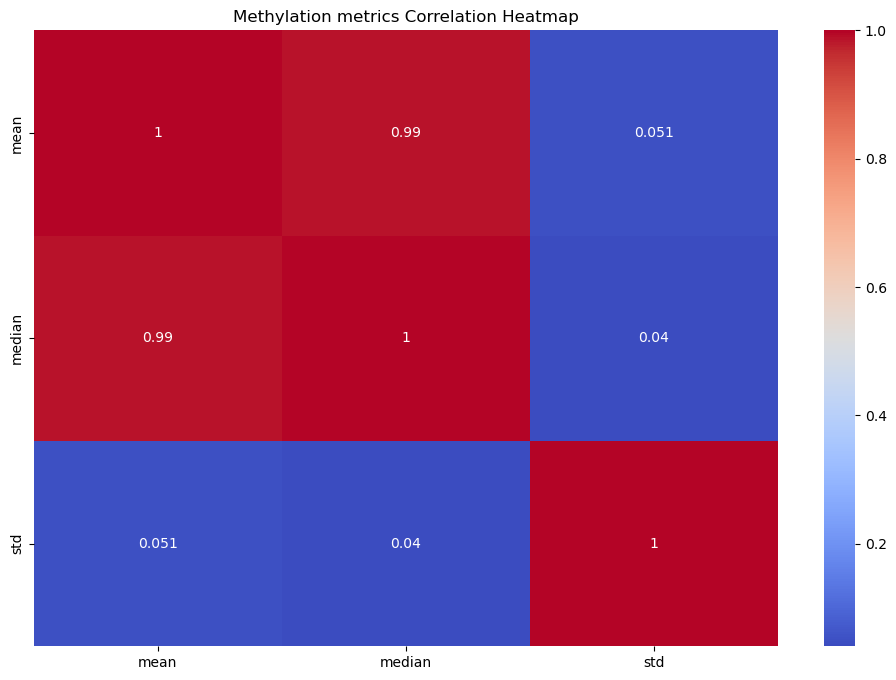

        mean  median  std
mean    1.00    0.99 0.05
median  0.99    1.00 0.04
std     0.05    0.04 1.00


In [54]:
# Plot confusion matrix for methylation data
cols = ["mean", "median", "std"]  
corr_m = corr_matrix_plot(epi_df[cols], title_str='Methylation metrics Correlation Heatmap')
print(corr_m)

#### Keep mean or median? 

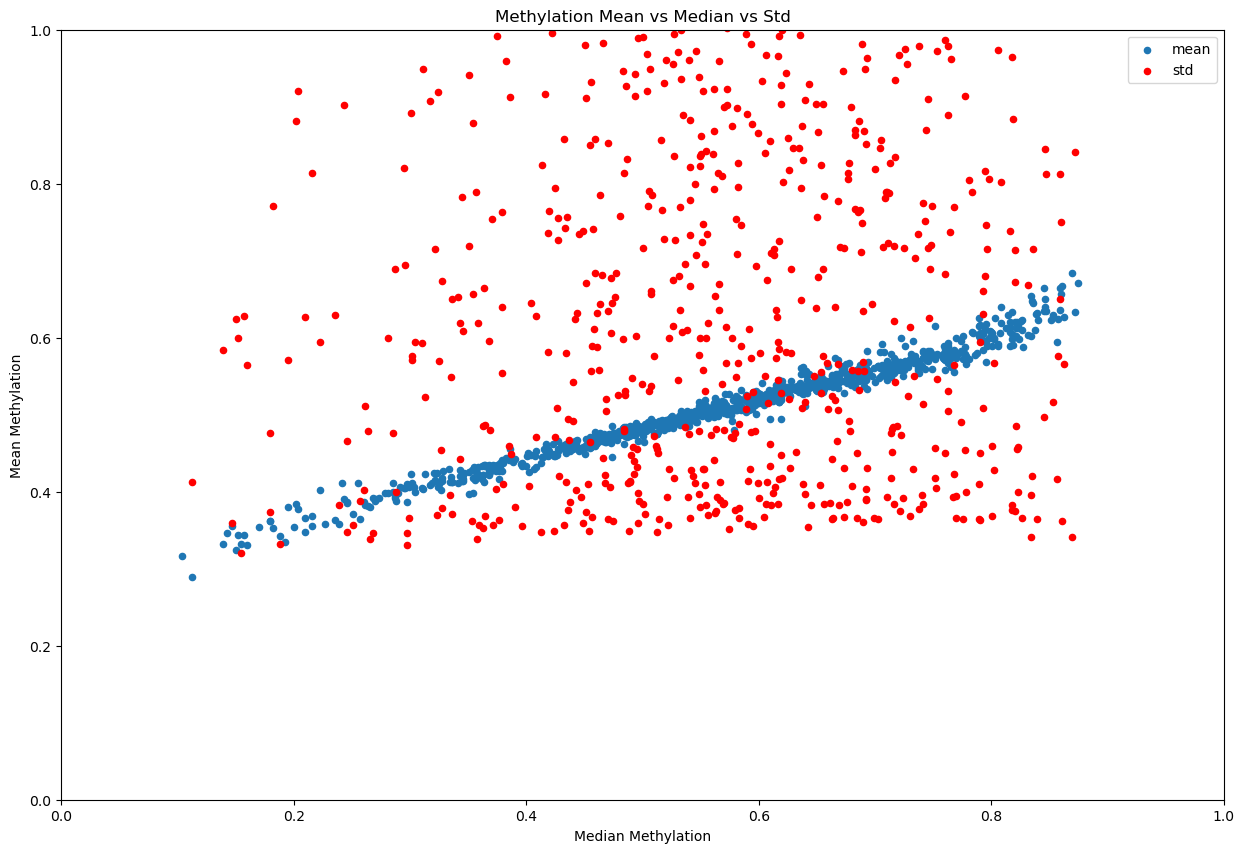

In [55]:
fig, ax = plt.subplots()
epi_df.plot.scatter(x='median',y='mean', ax=ax, label='mean')
epi_df.plot.scatter(x='median',y='std', ax=ax, color='red', label='std')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('Median Methylation')
ax.set_ylabel('Mean Methylation')
ax.set_title('Methylation Mean vs Median vs Std')
plt.legend()
plt.show()

Interpretation:

Drop:
* Drop mean: median has higher spread and captures levels slightly better, 99% correlation to median

Keep:
* median, std

In [56]:
# Drop columns
epi_df = epi_df.drop(columns=['mean'])
epi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   COSMIC_ID  912 non-null    int64  
 1   median     912 non-null    float32
 2   std        912 non-null    float32
dtypes: float32(2), int64(1)
memory usage: 14.4 KB


### Tidy column names for merging and set index for build epi_block

In [57]:
# tidy column names and set index
meth_block = (
    epi_df
      .rename(columns={"median": "meth_med", "std": "meth_std"})
      .set_index("COSMIC_ID")
                   # halves memory vs float64
)

## 3.6: Explore Mutation Data (mut_df)

 | 	Feature	 | 	Description	 | 	Action	 | 
 | 	--------	 | 	-----------	 | 	----------	 | 
 | 	SAMPLE	 | 	Sample identifier provided in study	 | 	Drop: 1:1 COSMIC_ID	 | 
 | 	COSMIC_ID	 | 	Unique numerical identifier for the cell lines used in COSMIC	 | 	Keep as key for all df	 | 
 | 	Cancer Type	 | 	TCGA tissue classification	 | 	Drop	 | 
 | 	Gene	 | 	Gene name from Ensembl version 56	 | 	Drop	 | 
 | 	Transcript	 | 	Transcript identifier from Ensembl version 56	 | 	Drop	 | 
 | 	cDNA	 | 	Variant position and nucleotide change relating to the cDNA	 | 	Drop	 | 
 | 	AA	 | 	Amno acid positon and alteration	 | 	Drop	 | 
 | 	Classification	 | 	Summary of variant type	 | 	Get totals by cell line per classification type	 | 
 | 	Gene List	 | 	Identifier for variants within the 470 genes used in the study	 | 	Drop after using to filter for high-confidenc driver genes	 | 
 | 	Recurrence Filter	 | 	Based on frequency observed in COSMIC (v68) (Recurrance filter: See Extended Experimental Procedures ) plus fusion gene data	 | 	Drop: captured by subs, truncating, inframe	 | 
 | 	Subs	 | 	Missense/substitution variants occurring in codons mutated in the systematic screen data in COSMIC (v68) (select >=3)	 | 	Drop: info in classification	 | 
 | 	Truncating	 | 	Truncating variant count from the systematic screen data in COSMIC (v68) (select >10)	 | 	Drop: info in classification	 | 
 | 	inframe	 | 	Inframe indel alterations occurring in codons mutated in the systematic screen data in COSMIC (v68) (select >=3)	 | 	Drop: info in classification	 | 

In [58]:
mut_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456760 entries, 0 to 456759
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              456760 non-null  int64  
 1   COSMIC_ID          456760 non-null  int64  
 2   cell_line          456760 non-null  object 
 3   cancer_type        382595 non-null  object 
 4   gene               456760 non-null  object 
 5   transcript         456760 non-null  object 
 6   cdna               456760 non-null  object 
 7   aa                 456760 non-null  object 
 8   classification     456760 non-null  object 
 9   gene_list          22750 non-null   object 
 10  recurrence_filter  27656 non-null   object 
 11  subs               49560 non-null   float64
 12  truncating         62259 non-null   float64
 13  inframe            409 non-null     float64
dtypes: float64(3), int64(2), object(9)
memory usage: 48.8+ MB


How many unique genes?

In [59]:
mut_df["gene"].nunique()

19067

### Determine which features to drop

#### Percent null values

In [60]:
# Check percent null
_ = remove_columns_with_missing_data(mut_df, 100)

There are a total of 456760 rows with the following percentage of missing data:
inframe              99.91%
gene_list            95.02%
recurrence_filter    93.95%
subs                 89.15%
truncating           86.37%
cancer_type          16.24%
index                 0.00%
COSMIC_ID             0.00%
cell_line             0.00%
gene                  0.00%
transcript            0.00%
cdna                  0.00%
aa                    0.00%
classification        0.00%
dtype: object

No columns with >100% missing data to drop


#### Evaluation of Truncation

In [61]:
mut_df['truncating'].value_counts()

truncating
3.00     4832
2.00     4789
4.00     4692
5.00     4266
1.00     3936
         ... 
58.00      26
77.00      25
83.00      13
70.00      12
88.00       8
Name: count, Length: 98, dtype: int64

In [62]:
mut_df.groupby(['COSMIC_ID'])['inframe'].sum().sort_values()

COSMIC_ID
683667     0.00
908481     0.00
908483     0.00
909194     0.00
909248     0.00
           ... 
1240146   18.00
753608    19.00
908129    19.00
909257    20.00
949177    24.00
Name: inframe, Length: 912, dtype: float64

#### Check uniqueness of mutation features

In [63]:
# check uniqueness
mut_df.nunique()

index                456760
COSMIC_ID               912
cell_line               912
cancer_type              30
gene                  19067
transcript            20922
cdna                  92073
aa                   173302
classification            8
gene_list                 4
recurrence_filter         1
subs                     52
truncating               98
inframe                  16
dtype: int64

#### Fix classification values with mistypes (caps vs lower)

In [64]:
# make all values lower case in 'classification' column to fix the caps of some missense
print("Unique classification values:")

pprint(mut_df.classification.value_counts())

# fix caps naming issues
mut_df['classification'] = mut_df['classification'].str.lower()

print("\nFixed Unique classification values:")
pprint(mut_df.classification.value_counts())

Unique classification values:
classification
missense       387756
frameshift      30324
nonsense        22105
ess_splice      12342
inframe          2949
Missense          801
stop_lost         450
gene_fusion        33
Name: count, dtype: int64

Fixed Unique classification values:
classification
missense       388557
frameshift      30324
nonsense        22105
ess_splice      12342
inframe          2949
stop_lost         450
gene_fusion        33
Name: count, dtype: int64


Interpretation: 
- Drop Recurrence Filter: already reflective in Subs / Truncating / Inframe (recurrence flags)

In [65]:
# make drop row list
mut_drop_cols = [
    'cell_line', # have in lookup table from comsic_id
    'recurrence_filter', # captured by subs, truncating, inframe
    ]
# mut_df = mut_df.drop(mut_drop_rows, axis=1)
# dict_features['mut_df: recurrence_filter'] = 'Drop: already reflective in Subs / Truncating / Inframe (recurrence flags)'
# dict_features['mut_df: gene_list'] = 'Drop: informative for 470 of 400k+ genes (95% missing)'

#### Reduce mutation data to the high-confidence driver genes 
By reducing the list of genes needed, the cost of a diagnostic assay can be reduced.

In [66]:
mut_df.gene_list.unique()

array([nan, 'IntOGen pipeline', 'IntOGen pipeline,Wong et al 2014',
       'Wong et al 2014', 'Fusion Gene'], dtype=object)

In [67]:
print(f"Shape of mut_df before keeping only high-confidenc driver genes:{mut_df.shape}")
print(f"\tWith {mut_df.gene.nunique()} unique genes at the start.")
mut_df = mut_df.loc[mut_df['gene_list'].notna()]
print(f"\tShape after: {mut_df.shape}")
print(f"\tWith {mut_df.gene.nunique()} unique genes at the end.")

mut_drop_cols.append('gene_list')

Shape of mut_df before keeping only high-confidenc driver genes:(456760, 14)
	With 19067 unique genes at the start.
	Shape after: (22750, 14)
	With 478 unique genes at the end.


### Make 0/1 boolean for the high-confidence genes -> gene_matrix

### map gene + classification

In [68]:
mut_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22750 entries, 1929 to 455480
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              22750 non-null  int64  
 1   COSMIC_ID          22750 non-null  int64  
 2   cell_line          22750 non-null  object 
 3   cancer_type        19168 non-null  object 
 4   gene               22750 non-null  object 
 5   transcript         22750 non-null  object 
 6   cdna               22750 non-null  object 
 7   aa                 22750 non-null  object 
 8   classification     22750 non-null  object 
 9   gene_list          22750 non-null  object 
 10  recurrence_filter  5002 non-null   object 
 11  subs               3348 non-null   float64
 12  truncating         4539 non-null   float64
 13  inframe            73 non-null     float64
dtypes: float64(3), int64(2), object(9)
memory usage: 2.6+ MB


In [69]:
mut_df.classification.value_counts()

classification
missense       17920
frameshift      2248
nonsense        1539
ess_splice       770
inframe          226
gene_fusion       33
stop_lost         14
Name: count, dtype: int64

In [70]:
# # assume mut_df now has only driver genes
mut_df["flag"] = 1

# Map classifications to feature columns
def bucket_classifications(classif: str) -> str:
    if classif in {"missense_variant", "stop_lost"}:
        return "miss"
    elif classif in {"stop_gained", "frameshift_variant"}:
        return "trunc"
    elif "inframe" in classif:
        return "indel"
    else:                        # optional catch-all
        return "other"

mut_df["var_grp"] = mut_df["classification"].map(bucket_classifications)

# generate table with each genename_vargrp if there is an occarance in the data set (expect more than 478 (up to 3x478))
mut_by_type_df= (
    mut_df.pivot_table(index="COSMIC_ID",
                       columns=["gene", "var_grp"],
                       values="flag",
                       aggfunc="max",        # any variant ⇒ 1
                       fill_value=0)
)

# flatten the MultiIndex columns
mut_by_type_df.columns = [
    f"{gene}_{grp}" for gene, grp in mut_by_type_df.columns
]

mut_by_type_df = mut_by_type_df.astype("float32")
mut_by_type_df.head()

# get a per-gene "any-mutation" column alongside the split
mut_any_type_df = (
    mut_by_type_df.groupby(mut_by_type_df.columns.str.split("_").str[0], axis=1).max()
         .add_suffix("_mut")
)

mut_block = pd.concat([mut_any_type_df, mut_by_type_df], axis=1)


In [71]:
mut_block.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 683667 to 1674021
Columns: 1102 entries, ABCB1_mut to ZNRF3_other
dtypes: float32(1102)
memory usage: 3.8 MB


In [72]:
print("mut_any_type_df: ", mut_any_type_df.shape)
print("mut_by_type_df:  ", mut_by_type_df.shape)
#print("gene_matrix: ", gene_matrix.shape)

mut_any_type_df:  (912, 478)
mut_by_type_df:   (912, 624)


## 3.7: Explore Expression Data (expr_df)

Gene by cell line matrix of expression levels

In [73]:
expr_df.shape

(17737, 913)

### cleanup column names to ensure no .1 .2 replicates



In [74]:
# ensure clean naming of columns
expr_df.rename(columns={"ensembl_gene": "gene"}, inplace=True)


In [75]:
expr_df.columns

Index([ 'gene',  683667,  684052,  684057,  684059,  684062,  684072,  687448,
        687455,  687457,
       ...
       1524418, 1524419, 1659818, 1659823, 1659928, 1659929, 1660034, 1660035,
       1660036, 1674021],
      dtype='object', length=913)

### Get top 5000 genes by variance to reduce compute
The value of 5000 is configurable.


In [76]:
# Drop low variance genes
var = expr_df.drop(columns=['gene']).var(axis=1)

top_genes = expr_df.loc[var.nlargest(5_000).index]

# Transpose to cosmic_id rows and make int index from COSMIC_IDs
expr_long = top_genes.set_index("gene").T
expr_long.index.name = "COSMIC_ID"
expr_long.index = expr_long.index.astype(int) # make int index 

# Center and Scale expression using z-score so PCA and models aren't dominated by high-expression genes
expr_scaled = (expr_long - expr_long.mean()) / expr_long.std(ddof=0)



Dimenssionally reduction to retains most signal, cuts collinearity.
- 912 cell lines × 5 000 genes → 30–100 PCs  

In [77]:
# Dimensionality reduction → PCs** | 

pca = PCA(n_components=100, random_state=0)
pc_array = pca.fit_transform(expr_scaled.fillna(0).values)
expr_pc = (
    pd.DataFrame(pc_array,
                 index=expr_scaled.index,
                 columns=[f"expr_PC{i+1}" for i in range(pc_array.shape[1])])
).astype("float32")



### Generate expr_block and expr_explained, for merging with other data and lookup for plotting

In [78]:
# Create the final `expr_block`
expr_block = expr_pc          # rows = COSMIC_ID, cols = expr_PC*
print(expr_block.shape)       # e.g. (912 cell lines × 100 PCs)

# Keep metadata separately:  Keep the `pca.components_` matrix and gene lists for plots—not in the training matrix.
expr_explained = pd.Series(pca.explained_variance_ratio_,
                      name="var_exp").cumsum()
expr_explained.to_csv(DATA_DIR /  "expr_pca_variance.csv")


(912, 100)


## 3.8: Store all datasets (_blocks) and lookup tables in hd5 file for easy access

In [79]:
# Write dataa into one .h5 file
with pd.HDFStore(DATA_DIR / 'gbdc_blocks_w_lookups_2.h5', mode='w') as store:
    store['drug_lookup'] = drug_lookup
    store['drug_df'] = drug_df
    store['cell_lookup'] = cell_lookup
    store['cell_block'] = cell_block
    store['dose_df'] = dose_df
    store['ic50_block'] = ic50_block
    store['zscore_block'] = zscore_block
    store['meth_block'] = meth_block
    store['mut_block']  = mut_block
    store['expr_block'] = expr_block

    # …add as many as you like

In [80]:
all_process_time = (time.time() - start_time_all)

from datetime import timedelta

print(f"Processing time from beginning to .h5 file write out: {str(timedelta(seconds=all_process_time))}")

Processing time from beginning to .h5 file write out: 0:01:13.551222


# 4. Visualize Independent Data Sets

## 4.1: Explore cell line information

In [81]:
cell_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   index              912 non-null    int64 
 1   COSMIC_ID          912 non-null    int64 
 2   cell_line          912 non-null    object
 3   tissue_desc_1      912 non-null    object
 4   tissue_desc_2      912 non-null    object
 5   cancer_type        751 non-null    object
 6   msi                910 non-null    object
 7   growth_properties  912 non-null    object
dtypes: int64(2), object(6)
memory usage: 57.1+ KB


In [82]:
# Plot growth properities by cell line cancer type
fig = plot_sunburst(cell_df, ['tissue_desc_1','tissue_desc_2','cancer_type'], 'Cancer Types by Tissue Desc 1 and Tissue Desc 2')
fig.write_image(
    RESULTS_DIR / 'cancer_types_by_tissue_desc.png', 
    width=fig.layout.width,      
    height=fig.layout.height,     
    scale=3      # scale up for better resolution
)
fig.show()

In [83]:
# Plot growth properities by cell line cancer type
fig = plot_sunburst(cell_df, ['cancer_type', 'growth_properties'], 'Growth Properties of Cancer Types')

fig.write_image(
    RESULTS_DIR / 'cancer_types_by_growth_properties.png', 
    width=fig.layout.width,      
    height=fig.layout.height,     
    scale=3      # scale up for better resolution
)
fig.show()


In [84]:
drug_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286 entries, 220 to 620
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   drug_id         286 non-null    int64 
 1   target          249 non-null    object
 2   target_pathway  286 non-null    object
dtypes: int64(1), object(2)
memory usage: 8.9+ KB


In [85]:
dose_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224104 entries, 0 to 230636
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             224104 non-null  int64  
 1   COSMIC_ID         224104 non-null  int64  
 2   cancer_type_tcga  223224 non-null  object 
 3   drug_id           224104 non-null  int64  
 4   target            198151 non-null  object 
 5   pathway           224104 non-null  object 
 6   ln_ic50           224104 non-null  float64
 7   auc               224104 non-null  float64
 8   rmse              224104 non-null  float64
 9   z_score           224104 non-null  float64
dtypes: float64(4), int64(3), object(3)
memory usage: 18.8+ MB


In [86]:
# Plot growth properities by cell line cancer type
fig = plot_sunburst(dose_df, ['pathway','target'], 'Drug Target by Pathway - All Drugs')
#plt.savefig(RESULTS_DIR / 'drug_target_by_pathway.png', dpi=300, bbox_inches='tight')


fig.write_image(
    RESULTS_DIR / 'drug_target_by_pathway.png', 
    width=fig.layout.width,      
    height=fig.layout.height,     
    scale=3      # scale up for better resolution
)
fig.show()

Prepare data for plotting

In [87]:
# bring in drug_name for plots
dose_df = dose_df.merge(
    drug_lookup[['drug_name']],
    left_on='drug_id',
    right_index=True,
    how='left'
)

dose_df = dose_df.merge(
    cell_df
      .set_index('COSMIC_ID')[['cell_line','cancer_type','tissue_desc_1','tissue_desc_2']],
    left_on='COSMIC_ID',
    right_index=True,
    how='left'
)



In [88]:
# list of working drug_names and drug_ids (subset of all drugs)
drugs_to_analyze = ['Cisplatin', 
                    'Docetaxel', 'Doxorubicin', 
                    'Epirubicin',  'Erlotinib',
                    'Gefitinib', 'Gemcitabine', 
                    'Navitoclax',
                    'Paclitaxel', 
                    'Sorafenib', 'Temozolomide']

# 'Docetaxel', 'Doxorubicin', 
# 

drug_set_ids = drug_lookup[drug_lookup['drug_name'].isin(drugs_to_analyze)].index
print(drug_set_ids)


# Option A: filter by name
mask = dose_df['drug_name'].isin(drugs_to_analyze)
subset_df = dose_df.loc[mask]

# # — or —

# # Option B: filter by drug_id 
# drug_set_ids = drug_lookup.loc[drug_lookup['drug_name'].isin(drugs_to_analyze)].index
# subset_df = dose_df[dose_df['drug_id'].isin(drug_set_ids)]

#drug subset information
fig = plot_sunburst(
    subset_df,
    ['drug_name','pathway', 'target'],
    'Drug Target by Pathway – Selected Drugs',
    # color_continuous_scale= 'purples', #'bupu',#'RdBu',
)

# Save figure
fig.write_image(
    RESULTS_DIR / 'drug_target_by_pathway_selected_drugs.png', 
    width=fig.layout.width,      
    height=fig.layout.height,     
    scale=3      # scale up for better resolution
)
fig.show()


Index([1005, 1007, 1010, 1011, 1080, 1085, 1168, 1190, 1375, 1511], dtype='int64', name='drug_id')


In [89]:
#drug subset information
fig = plot_sunburst(
    dose_df,
    ['pathway', 'target','drug_name',],
    'Drug Target by Pathway – All Drugs'
)


# Save figure
fig.write_image(
    RESULTS_DIR / 'drug_target_by_pathway_all_drugs.png', 
    width=fig.layout.width,      
    height=fig.layout.height,     
    scale=3      # scale up for better resolution
)
fig.show()


In [90]:
plot_sunburst(
    dose_df,
    ['pathway', 'drug_name',],
    'Drug name by Pathway'
)

In [91]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8880 entries, 1637 to 82445
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             8880 non-null   int64  
 1   COSMIC_ID         8880 non-null   int64  
 2   cancer_type_tcga  8834 non-null   object 
 3   drug_id           8880 non-null   int64  
 4   target            8880 non-null   object 
 5   pathway           8880 non-null   object 
 6   ln_ic50           8880 non-null   float64
 7   auc               8880 non-null   float64
 8   rmse              8880 non-null   float64
 9   z_score           8880 non-null   float64
 10  drug_name         8880 non-null   object 
 11  cell_line         8880 non-null   object 
 12  cancer_type       7309 non-null   object 
 13  tissue_desc_1     8880 non-null   object 
 14  tissue_desc_2     8880 non-null   object 
dtypes: float64(4), int64(3), object(8)
memory usage: 1.1+ MB


In [92]:
plot_sunburst(
    subset_df,
    ['target','cancer_type_tcga'],
    'Drug Target by cancer type – Select Drugs'
)



# Save figure
fig.write_image(
    RESULTS_DIR / 'drug_target_by_cnacer_suelect_drugs.png', 
    width=fig.layout.width,      
    height=fig.layout.height,     
    scale=3      # scale up for better resolution
)
fig.show()

In [93]:
plot_treemap(
    subset_df,
    ['drug_name','pathway',],
    'Drug by pathway and cell_type'
)

# 5: Data Merging

## 5.1: Reload data if needed

In [94]:
# load data form file 
reload_data = True
if reload_data:
    with pd.HDFStore(DATA_DIR / 'gbdc_blocks_w_lookups_2.h5', mode='r') as store:
        drug_lookup = store['drug_lookup']
        drug_df = store['drug_df']
        dose_df = store['dose_df']
        cell_lookup = store['cell_lookup']
        cell = store['cell_block']
        ic50 = store['ic50_block']
        zscore = store['zscore_block']
        meth = store['meth_block']
        mut = store['mut_block']
        expr = store['expr_block']

## 5.2 Build df_merged: Merge dose_df with Cell Line, Methylation, Mutation and Drug Features

In [95]:
# merge all data into df_merged
df_merged = dose_df.copy()


# Merge Cell Line Features
# Ensure 'cell' dataframe's index is COSMIC_ID for merging
cell_features = cell.set_index(cell.index) # Assuming cell.index is already COSMIC_ID
df_merged = pd.merge(df_merged, cell_features.drop(columns=['index', 'cell_line'], errors='ignore'),
                     on='COSMIC_ID', how='left')


# Merge Drug Features
# Use drug_df for drug features, ensuring drug_id is the key
df_merged = pd.merge(df_merged, drug_df, on='drug_id', how='left')

# Merge Methylation, Mutation, and Expression data
df_merged = pd.merge(df_merged, meth, on='COSMIC_ID', how='left')
df_merged = pd.merge(df_merged, expr, on='COSMIC_ID', how='left')
df_merged = pd.merge(df_merged, mut, on='COSMIC_ID', how='left')

# drop 'index' column if it exists in any of the merged dataframes
if 'index' in df_merged.columns:
    df_merged = df_merged.drop(columns=['index'])


# drop duplicate target_y
df_merged = df_merged.rename(columns={'target_x': 'target'})
df_merged = df_merged.drop(columns=['target_y'])

# Handle Missing Values in Target Variable (LN_IC50)
# Drop rows where LN_IC50 is NaN, as these cannot be used for training.
initial_rows = len(df_merged)
df_merged.dropna(subset=['ln_ic50'], inplace=True)
print(f"Dropped {initial_rows - len(df_merged)} rows with missing LN_IC50 values.")

print("First n columns of df_merged: ")
pprint(df_merged.columns[0:20])

Dropped 0 rows with missing LN_IC50 values.
First n columns of df_merged: 
Index(['COSMIC_ID', 'cancer_type_tcga', 'drug_id', 'target', 'pathway',
       'ln_ic50', 'auc', 'rmse', 'z_score', 'tissue_desc_1', 'tissue_desc_2',
       'cancer_type', 'msi', 'growth_properties', 'target_pathway', 'meth_med',
       'meth_std', 'expr_PC1', 'expr_PC2', 'expr_PC3'],
      dtype='object')


# 6: EDA Round 2 - Study Merged Data and Feature Engineering

## 6.1 Check if Cancer_type and cancer_type_tcga are the same and merge if not

In [96]:
_ = are_columns_effectively_the_same(df_merged[['cancer_type']], df_merged[['cancer_type_tcga']])


Num Unique cancer_type:	31: Num null 40050
Num Unique cancer_type_tcga:	32: Num null 880
NOT THE SAME: There is a different # of nunique between columns



What is the difference between cancer_type and cancer_type_tcga? Can they be merged?

In [97]:
# Find rows where cancer_type and cancer_type_tcga differ
diff_rows = df_merged[df_merged['cancer_type'] != df_merged['cancer_type_tcga']][['cancer_type', 'cancer_type_tcga']]

# Print all differing pairs
# print("Rows where cancer_type and cancer_type_tcga differ:")
# pprint(diff_rows)

# Get unique pairs of differing values
print("Are there any unique pairs of differing values in cancer_type and cancer_type_tcga?")
unique_pairs = diff_rows.drop_duplicates()
print("\nUnique differing pairs (cancer_type, cancer_type_tcga):")
pprint(unique_pairs.values.tolist())


Are there any unique pairs of differing values in cancer_type and cancer_type_tcga?

Unique differing pairs (cancer_type, cancer_type_tcga):
[[nan, 'UNCLASSIFIED'],
 ['UNABLE TO CLASSIFY', 'UNCLASSIFIED'],
 ['COAD/READ', 'COREAD'],
 [nan, nan],
 [nan, 'OTHER'],
 ['SCLC', nan],
 ['COAD/READ', nan]]


**Interpretation**
cancer_type_tcga is a more up to date version of cancer_type and has fewer null values.

Next:
- use cancer_type_tcga to fill in null values for cancer_type and drop
- change nan mapped to other to other
- keep 'SCLC' over nan
- rename COAD/READ to COREAD
- change 'unable to classify' to 'unclassified' and set all remaining nan to unclassified

### Fill in cancer_type missing values from cancer_type_tcga and also fillna with UNCLASSIFIED

In [98]:
# Fill missing cancer_type from cancer_type_tcga
df_merged['cancer_type'] = (
    df_merged['cancer_type']
    .fillna(df_merged['cancer_type_tcga'])
)

# Replace the special “UNABLE TO CLASSIFY” label
df_merged['cancer_type'] = df_merged['cancer_type'] \
    .replace('UNABLE TO CLASSIFY', 'UNCLASSIFIED')

# Rename COAD/READ to COREAD
df_merged['cancer_type'] = df_merged['cancer_type'].replace('COAD/READ', 'COREAD')

# Fill missing cancer_type from cancer_type_tcga
df_merged['cancer_type'] = df_merged['cancer_type'].fillna(df_merged['cancer_type_tcga'])

# Fill remaining NaN values in cancer_type with 'UNCLASSIFIED'
df_merged['cancer_type'] = df_merged['cancer_type'].fillna('UNCLASSIFIED')

# # drop the now-redundant column
df_merged = df_merged.drop(columns='cancer_type_tcga')

# Check the old TCGA counts if you really need them
#pprint(df_merged.cancer_type.isna().sum())
#print(df_merged['cancer_type'].value_counts())

## 6.2: Get column headers by dataset for trained models on different data sets (per table below)

The following combination of data sets will be used to evaluate the contribution of methylation, mutation and expression to with the GDSC on model performance.

| 	Condition	 | 	GDSC	 | 	Methylation (M)	 | 	Mutation (V)	 | 	Expression (E)	 | 
| 	--------	 | 	-----------	 | 	--------	 | 	-----------	 | 	----------	 | 
| 	Impact of GDSC only *	 | 	Y	 | 		 | 		 | 		 | 
| 	Impact of GDSC with M	 | 	Y	 | 	Y	 | 		 | 		 | 
| 	Impact of GDSC with M + V	 | 	Y	 | 	Y	 | 	Y	 | 		 | 
| 	Impact of GDSC with  M + E	 | 	Y	 | 	Y	 | 		 | 	Y	 | 
| 	Impact of GDSC with  M + V + E	 | 	Y	 | 	Y	 | 	Y	 | 	Y	 | 
* Used for Base Models and Selection of the Best Model		

In [99]:
# Get colums to exclude from training set during model training and evaluation

# get methylation features excluding COSMIC_ID
cols_M = meth.columns.to_list()
cols_M = [x for x in cols_M if x not in ['COSMIC_ID']]
print(f"Number of methylation features: {len(cols_M)}")

# get mutation (variant) features excluding COSMIC_ID
cols_V = mut.columns.to_list()
cols_V = [x for x in cols_V if x not in ['COSMIC_ID']]
print(f"Number of mutation features: {len(cols_V)}")

# Get expression features excluding COSMIC_ID
cols_E = expr.columns.to_list()
cols_E = [x for x in cols_E if x not in ['COSMIC_ID']]
print(f"Number of expression features: {len(cols_E)}")
#pprint(cols_E)

# get colums for target variable
cols_T = ['ln_ic50', 'auc', 'z_score', 'rmse']

# get core GTCS related features
cols_core = set(df_merged.columns.to_list()) - (set(cols_T) | set(cols_M) | set(cols_V) | set(cols_E)) 
print(f"Number of core GTCS related features: {len(cols_core)}:")
#pprint(cols_core)

# setup experimental feature sets
cols_CM   = cols_core.union(cols_M)  # Core + Methylation
cols_CMV  = cols_CM.union(cols_V)  # Core + Methylation + Mutation
cols_CME  = cols_CM.union(cols_E) # Core + Methylation + Expression
cols_CMVE = cols_CMV.union(cols_E)  # Core + Methylation + Mutation + Expression   

# Convert to lists for easier handling
cols_CM   = list(cols_CM)  # Core + Methylation
cols_CMV  = list(cols_CMV)  # Core + Methylation + Mutation
cols_CME  = list(cols_CME)  # Core + Methylation + Expression
cols_CMVE = list(cols_CMVE)  # Core + Methylation + Mutation + Expression
# Core features only in order to use in modeling
cols_C = ['COSMIC_ID','drug_id',  
          'pathway', 'target', 'target_pathway',
          'cancer_type',
          'growth_properties',  'tissue_desc_1', 'tissue_desc_2', 
          'msi',]
pprint(cols_C)
  #list(cols_core)  # Core features only

Number of methylation features: 2
Number of mutation features: 1102
Number of expression features: 100
Number of core GTCS related features: 10:
['COSMIC_ID',
 'drug_id',
 'pathway',
 'target',
 'target_pathway',
 'cancer_type',
 'growth_properties',
 'tissue_desc_1',
 'tissue_desc_2',
 'msi']


In [100]:
len(cols_C), len(cols_T), len(cols_CMV), len(cols_CME), len(cols_CMVE),

(10, 4, 1114, 112, 1214)

### Rearrange columns for easier viewing of non mut and expr datframes that have large numbers of features.


In [101]:
# # Get columns in df_merged that are NOT in mut or expr dataframes
# cols_skip = mut.columns.to_list() + expr.columns.to_list()
# non_redundant_cols = [col for col in df_merged.columns.to_list() if col not in cols_skip]
# #pprint(non_redundant_cols)

# Rearrange columns in easier to view order
df_merged = df_merged[cols_C + cols_T + cols_M + cols_V + cols_E]
df_merged.columns[0:20]  # display first 20 columns for verification

Index(['COSMIC_ID', 'drug_id', 'pathway', 'target', 'target_pathway',
       'cancer_type', 'growth_properties', 'tissue_desc_1', 'tissue_desc_2',
       'msi', 'ln_ic50', 'auc', 'z_score', 'rmse', 'meth_med', 'meth_std',
       'ABCB1_mut', 'ABL2_mut', 'ACACA_mut', 'ACAD8_mut'],
      dtype='object')

## 6.3: Describe data

In [102]:
print("\nMerged DataFrame Info (Core GCSD only):")
df_merged[cols_C].info()



Merged DataFrame Info (Core GCSD only):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224104 entries, 0 to 224103
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   COSMIC_ID          224104 non-null  int64 
 1   drug_id            224104 non-null  int64 
 2   pathway            224104 non-null  object
 3   target             198151 non-null  object
 4   target_pathway     224104 non-null  object
 5   cancer_type        224104 non-null  object
 6   growth_properties  224104 non-null  object
 7   tissue_desc_1      224104 non-null  object
 8   tissue_desc_2      224104 non-null  object
 9   msi                223584 non-null  object
dtypes: int64(2), object(8)
memory usage: 17.1+ MB


In [103]:
print("\nMerged DataFrame Head:")
df_merged[cols_C].head().T




Merged DataFrame Head:


,0,1,2,3,4
COSMIC_ID,683667,684052,684057,684059,684062
drug_id,1003,1003,1003,1003,1003
pathway,DNA replication,DNA replication,DNA replication,DNA replication,DNA replication
target,TOP1,TOP1,TOP1,TOP1,TOP1
target_pathway,DNA replication,DNA replication,DNA replication,DNA replication,DNA replication
cancer_type,MB,UNCLASSIFIED,UNCLASSIFIED,UNCLASSIFIED,UNCLASSIFIED
growth_properties,Adherent,Adherent,Adherent,Adherent,Adherent
tissue_desc_1,nervous_system,soft_tissue,bone,bone,bone
tissue_desc_2,medulloblastoma,rhabdomyosarcoma,ewings_sarcoma,ewings_sarcoma,ewings_sarcoma
msi,MSS/MSI-L,MSS/MSI-L,MSS/MSI-L,MSS/MSI-L,MSS/MSI-L


### how many unique per the core features

In [104]:
df_merged[cols_C].nunique().sort_values(ascending=False)

# get specific columns starting with 'meth_'
# num_meth_cols = sum(col.endswith('_miss') for col in df_merged.columns)
# print(f"Number of columns starting with 'meth_': {num_meth_cols}")

COSMIC_ID            912
drug_id              286
target               185
tissue_desc_2         55
cancer_type           32
pathway               24
target_pathway        24
tissue_desc_1         19
growth_properties      3
msi                    2
dtype: int64

#### How many drugs per target

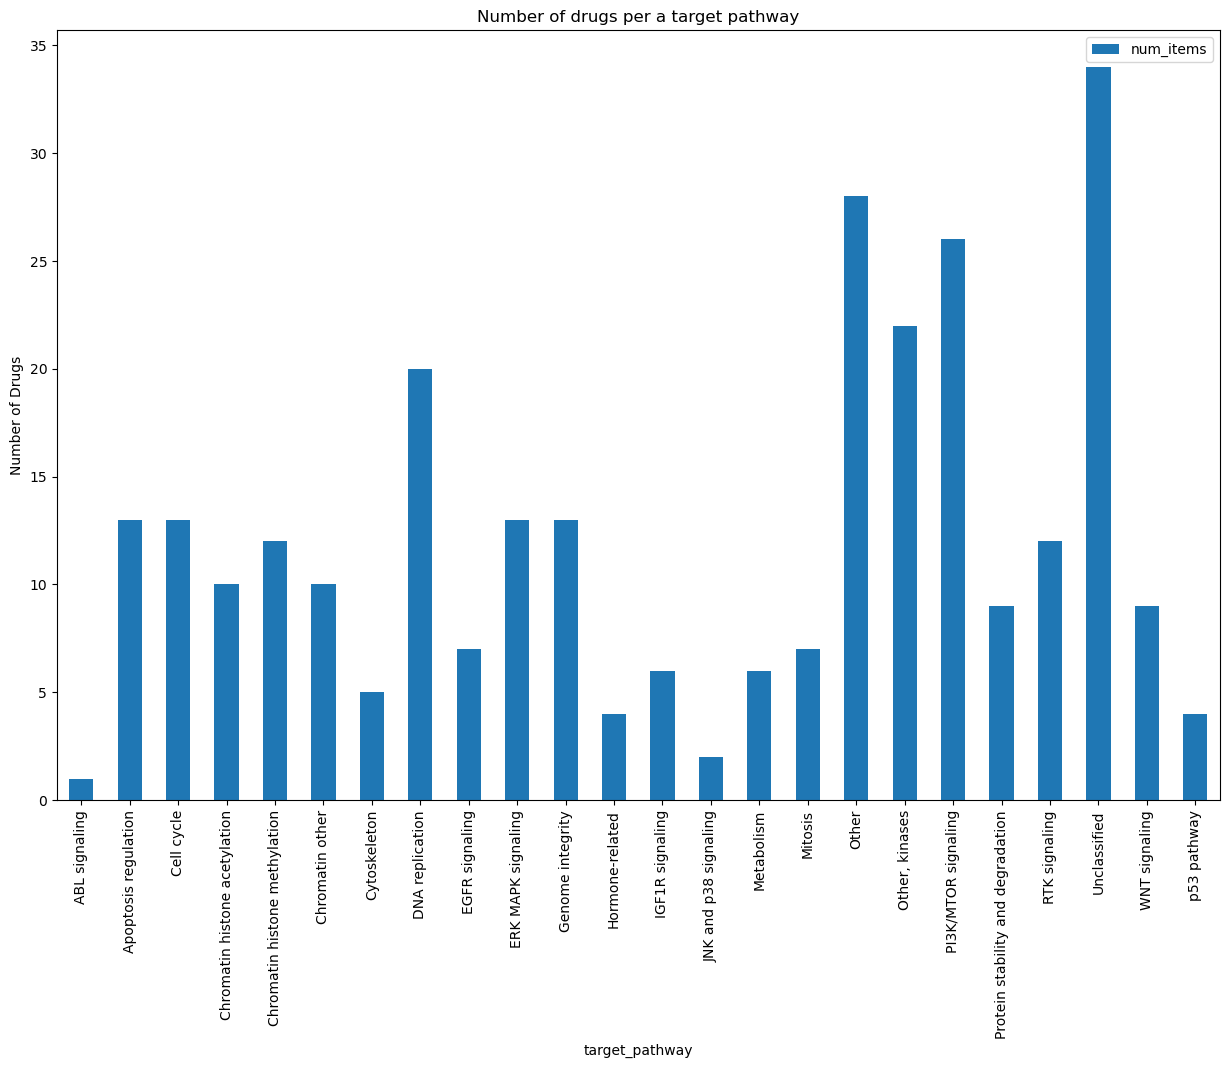

In [105]:
# How many drugs per target pathway?
_ = get_number_events(df_merged, 'target_pathway', 'drug_id').plot.bar(x='target_pathway',y='num_items')
plt.title("Number of drugs per a target pathway")
plt.ylabel("Number of Drugs")

plt.savefig( RESULTS_DIR / 'target_pathway_drug_count.png', dpi=300, bbox_inches='tight')
plt.show()

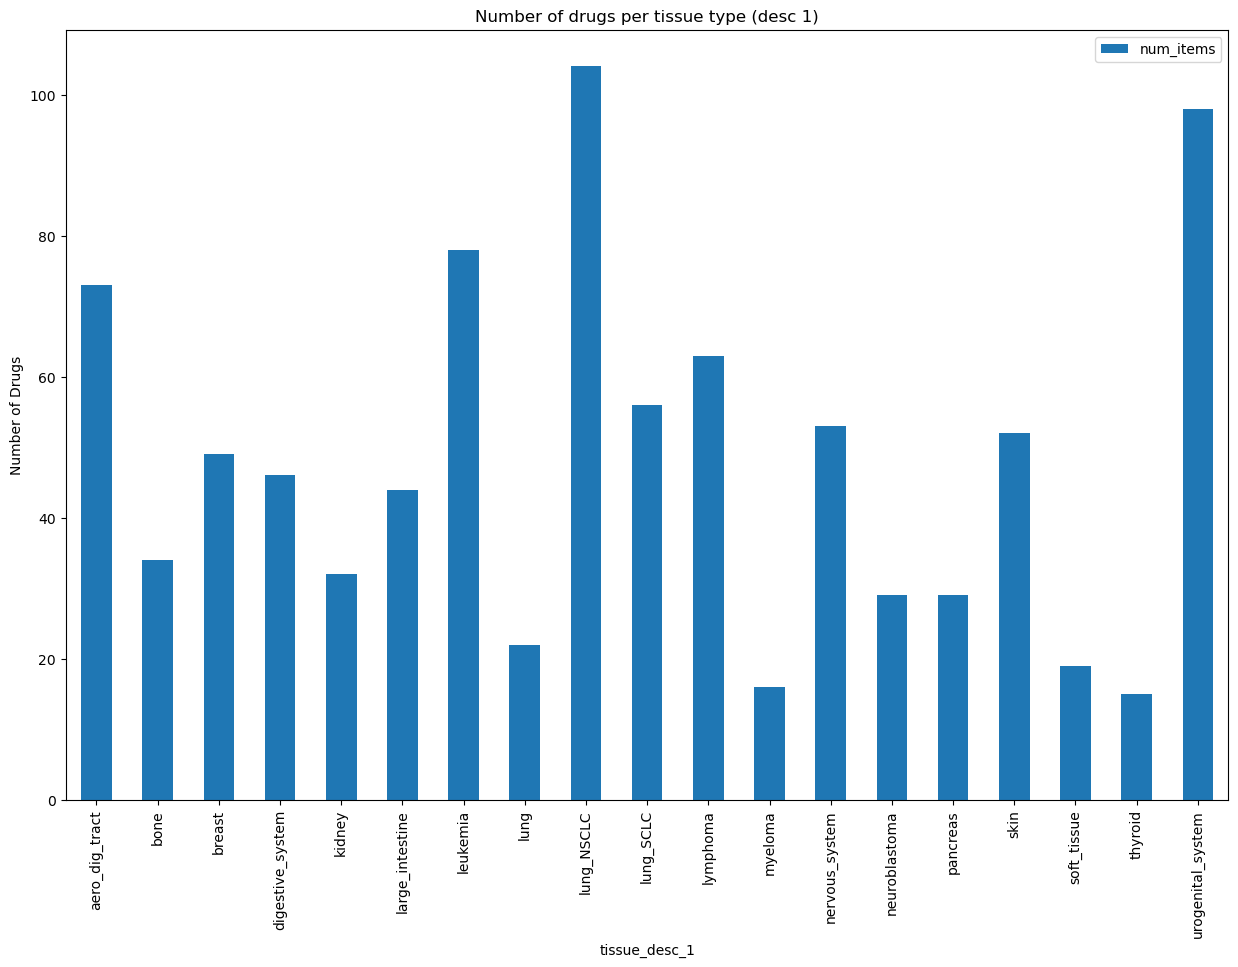

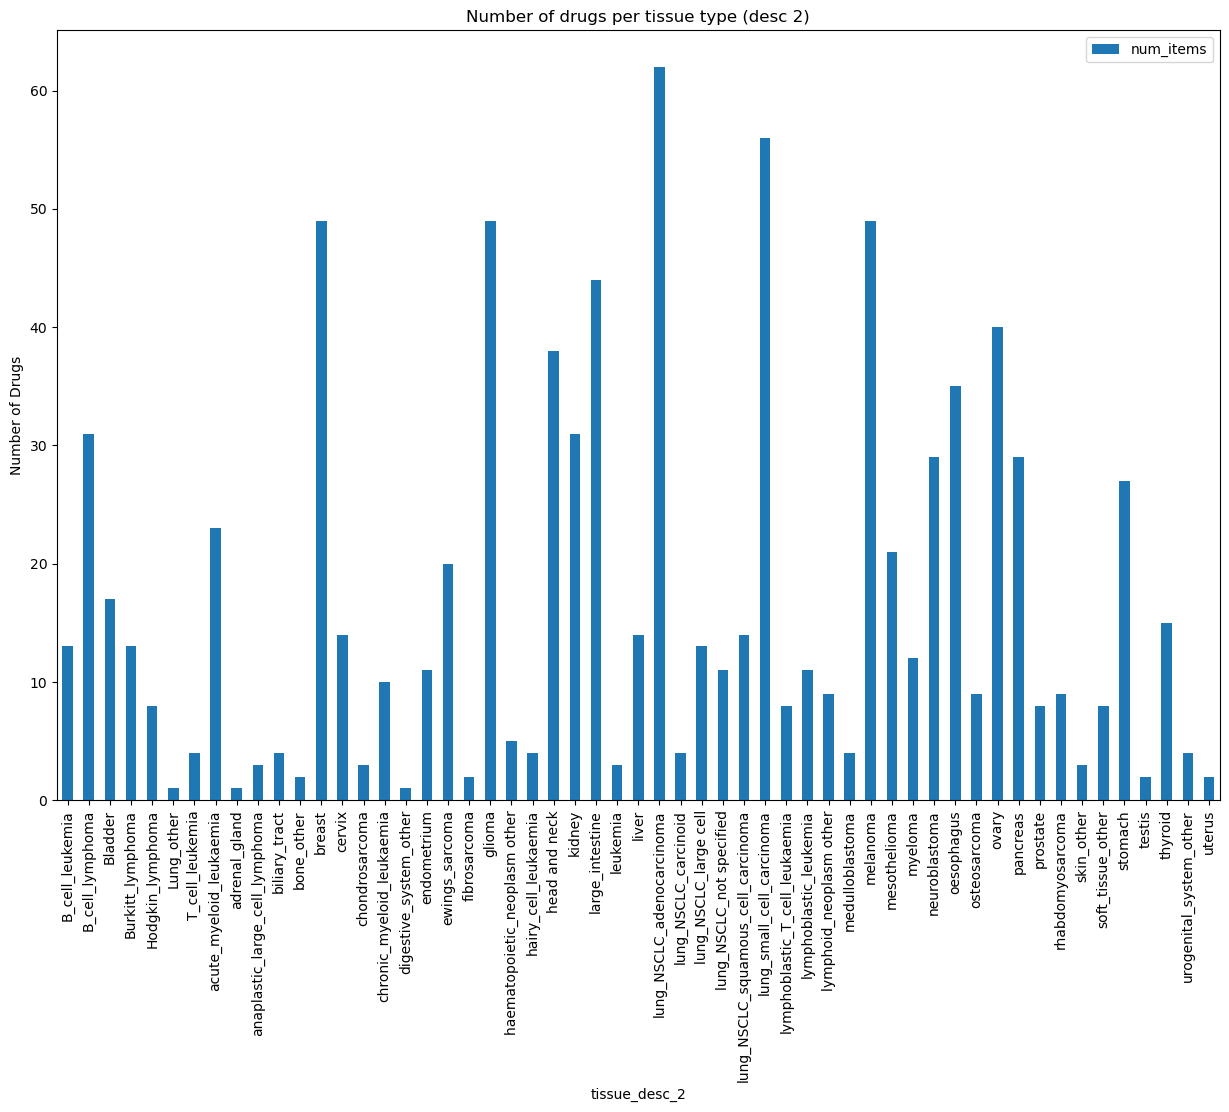

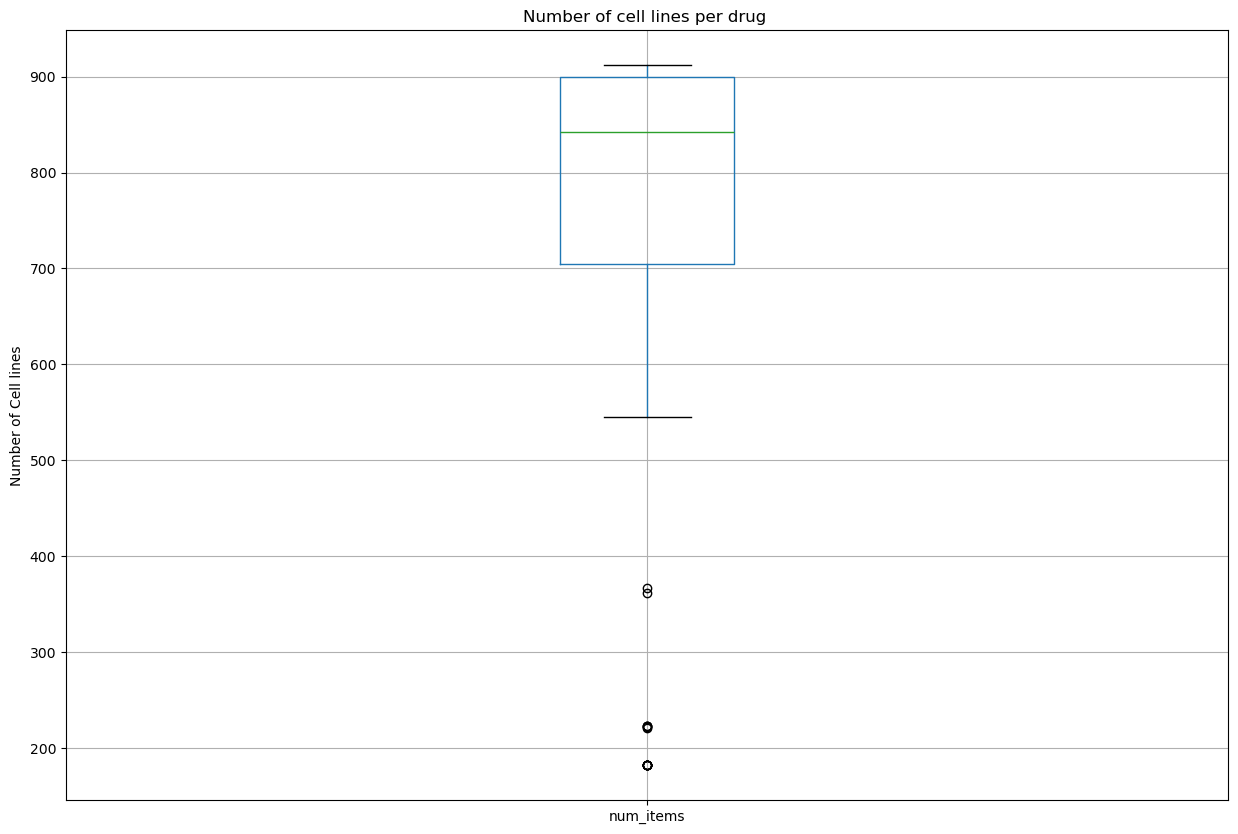

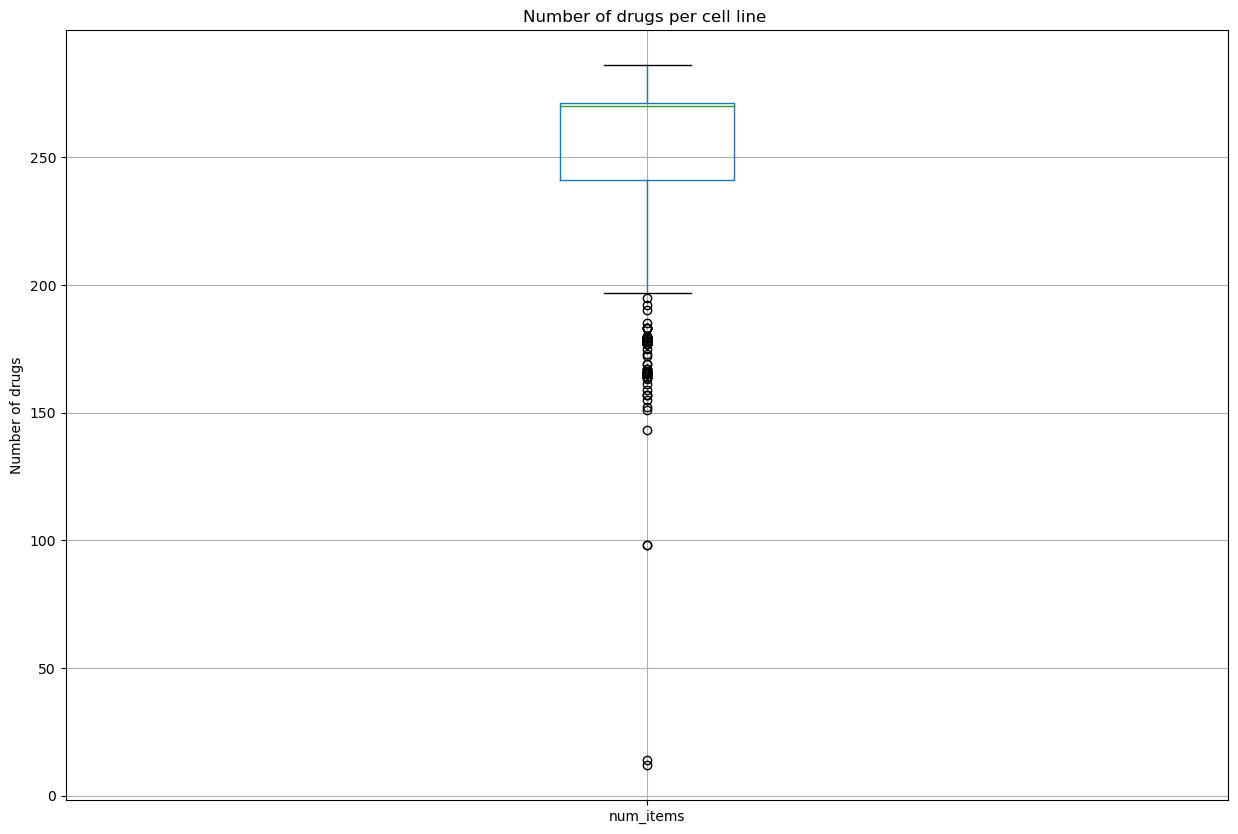

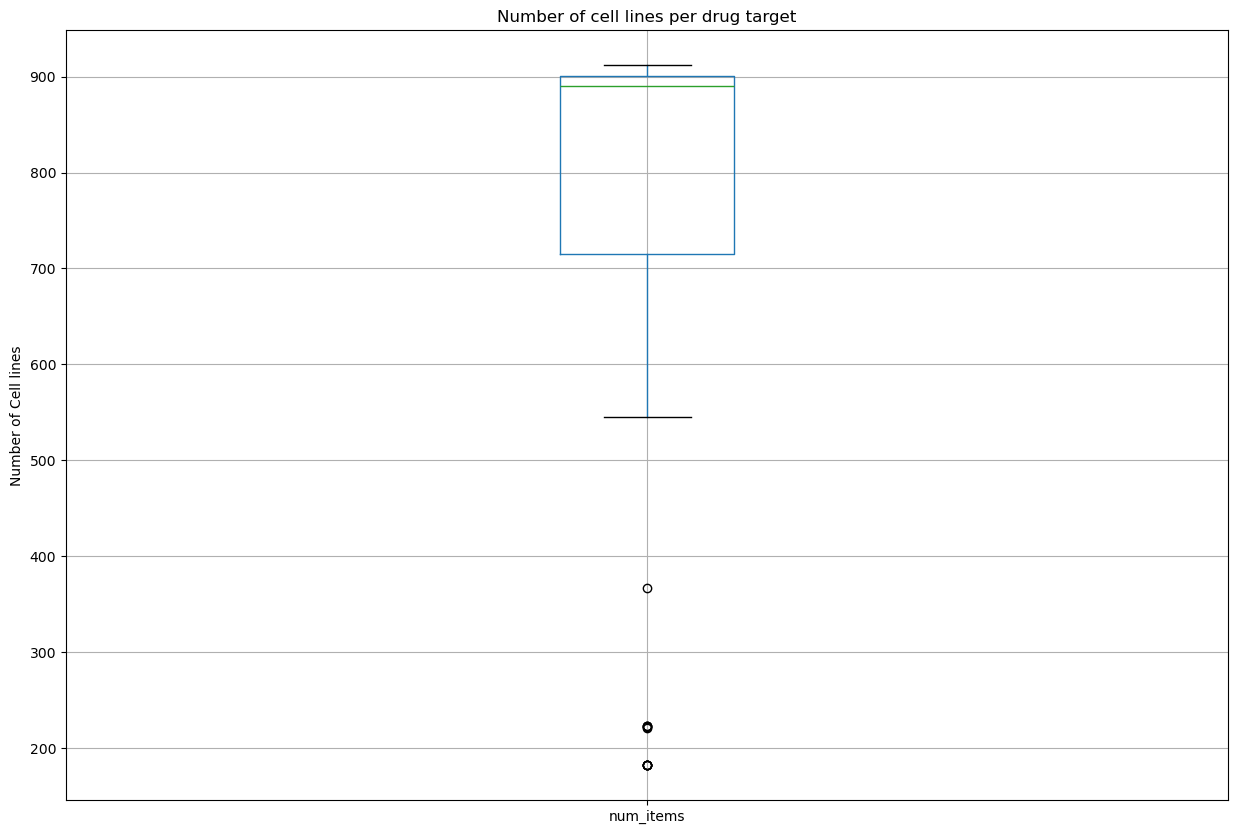

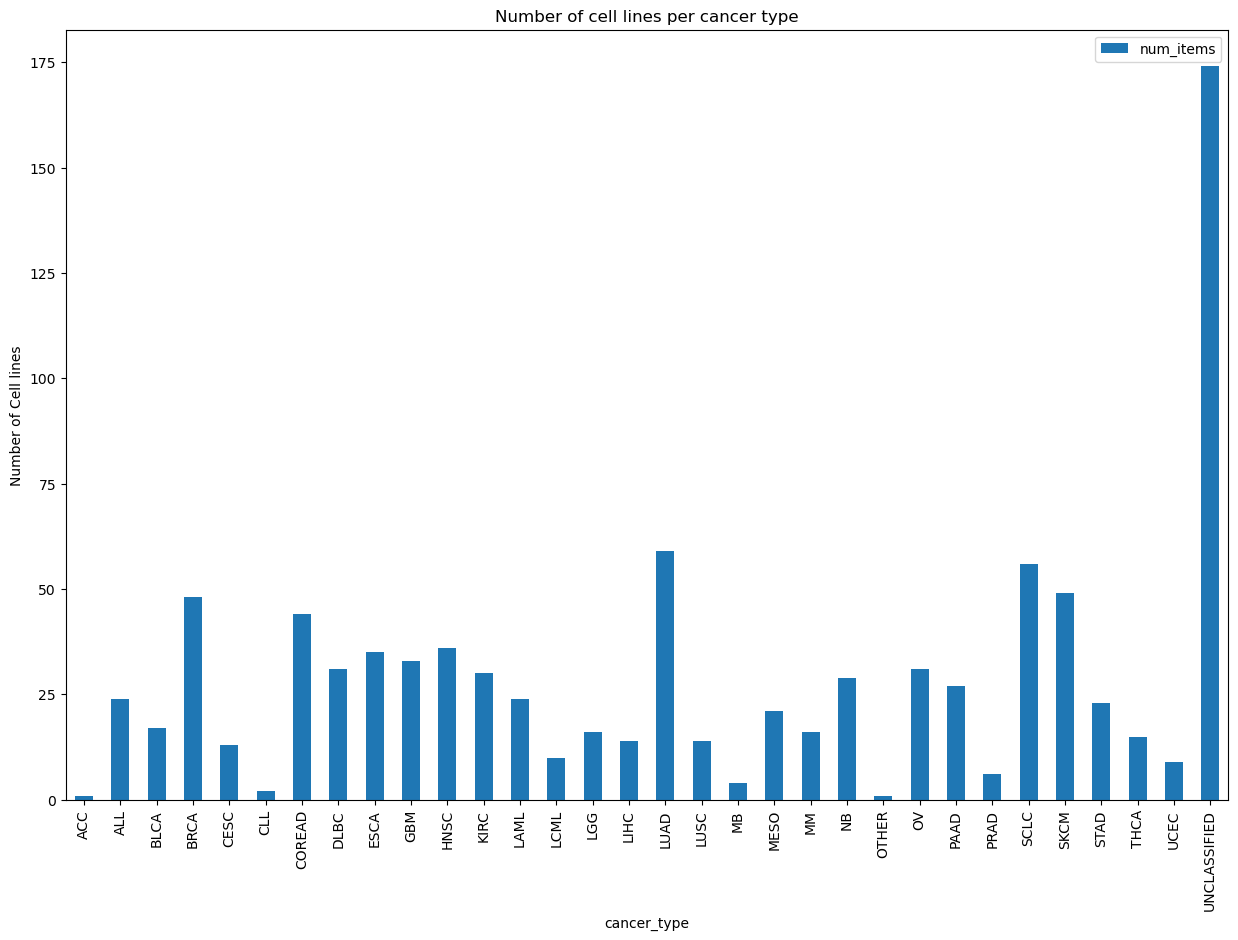

In [106]:
# merge low frequency cancer_types into other

_ = get_number_events(df_merged, 'tissue_desc_1', 'COSMIC_ID').plot.bar(x='tissue_desc_1',y='num_items')
plt.title("Number of drugs per tissue type (desc 1)")
plt.ylabel("Number of Drugs")
plt.savefig( RESULTS_DIR / 'drugs_per_tissue_1.png', dpi=300, bbox_inches='tight')
plt.show()

_ = get_number_events(df_merged, 'tissue_desc_2', 'COSMIC_ID').plot.bar(x='tissue_desc_2',y='num_items')
plt.title("Number of drugs per tissue type (desc 2)")
plt.ylabel("Number of Drugs")
plt.savefig( RESULTS_DIR / 'drugs_per_tissue_2.png', dpi=300, bbox_inches='tight')
plt.show()


_ = get_number_events(df_merged, 'drug_id', 'COSMIC_ID').boxplot(column='num_items')
plt.title('Number of cell lines per drug ')
plt.ylabel("Number of Cell lines")
plt.show()


_ = get_number_events(df_merged, 'COSMIC_ID', 'drug_id').boxplot(column='num_items')
plt.title('Number of drugs per cell line ')
plt.ylabel("Number of drugs")
plt.show()

_ = get_number_events(df_merged, 'target', 'COSMIC_ID').boxplot(column='num_items')
plt.title('Number of cell lines per drug target')
plt.ylabel("Number of Cell lines")
plt.show()

_ = get_number_events(df_merged, 'cancer_type', 'COSMIC_ID').plot.bar(x='cancer_type', y='num_items')
plt.title("Number of cell lines per cancer type")
plt.ylabel("Number of Cell lines")
plt.savefig( RESULTS_DIR / 'cells_per_cancer_type.png', dpi=300, bbox_inches='tight')
plt.show()


## REMOVE 6.4 Add binary ln_ic50 target for classification models
- Bin based on the top 0.25 quartile of each drug
- Save per drug cuttoffs for use in model evaluation 

In [107]:
# # binarize ln_ic50 based on quantile
# df_merged['binary_ln_ic50'] = (df_merged.groupby(['drug_id'])['ln_ic50']
#     .transform(lambda s: s < s.quantile(0.25))
#     .astype(int)
# )
# cols_T = cols_T + ['binary_ln_ic50']  # add binary_ln_ic50 to target columns

### REMOVE: How does the binary comapre to ln_50, auc and z_score (in total and by drug)

In [108]:
# ## plot binary_ln_ic50 by drug_id
# # Filter for a specific drug_id, e.g., 1008

# df_plot = df_merged[df_merged['drug_id'] == 1008]

# # cmopare
# xval='binary_ln_ic50'
# yval='auc'
# sns.boxplot(x=xval, y=yval, data=df_plot)
# plt.title("Comparison of ln_ic50 by binary_ln_ic50 group for all points (not by drug)")
# plt.xlabel(xval)
# plt.ylabel(yval)
# plt.show()

# # df_merged.plot.scatter(x='ln_ic50', y='z_score')
# xval='ln_ic50'
# yval='auc'
# sns.scatterplot(x=xval, y=yval, hue='binary_ln_ic50',  s=4,  data=df_plot, palette='Set1')
# plt.title("Comparison of ln_ic50 by binary_ln_ic50 group")
# plt.xlabel(xval)
# plt.ylabel(yval)
# plt.show()

# # df_merged.plot.scatter(x='ln_ic50', y='z_score')
# xval='ln_ic50'
# yval='z_score'
# sns.scatterplot(x=xval, y=yval, hue='binary_ln_ic50', data=df_plot, palette='Set1')
# plt.title("Comparison of ln_ic50 by binary_ln_ic50 group")
# plt.xlabel(xval)
# plt.ylabel(yval)
# plt.show()

# # Plot z_score distributions for each binary_ln_ic50 group on the same plot
# xval='binary_ln_ic50'
# yval='z_score'
# sns.boxplot(x='binary_ln_ic50', y='z_score', data=df_plot)
# plt.title("Comparison of z_score by binary_ln_ic50 group")
# plt.xlabel(xval)
# plt.ylabel(yval)
# plt.show()

# xval='binary_ln_ic50'
# yval='auc'
# sns.boxplot(x='binary_ln_ic50', y='auc', data=df_plot)
# plt.title("Comparison of auc by binary_ln_ic50 group")
# plt.xlabel(xval)
# plt.ylabel(yval)
# plt.show()

### REMOVE: Is there ambiguity in the binary_ln_ic5o 0-1 cuttoff on a per drug basis?
Plot will show that half of the drugs have > x% of samples in the ambiguous zone (overlap) between 0-1. And what the standard de

In [109]:
# # compute overlap fraction per drug
# def overlap_frac(g):
#     mask = (g['ln_ic50'] >= 0.5) & (g['ln_ic50'] <= 1)
#     return mask.sum() / len(g)

# overlap = df_merged.groupby('drug_id').apply(overlap_frac)

# # box-plot the distribution across drugs
# fig, ax = plt.subplots(figsize=(6,4))
# ax.boxplot(overlap.values)
# ax.set_ylabel("Fraction of ln_ic50 in [0,1]")
# ax.set_title("Ambiguity of 0–1 threshold across drugs")
# plt.tight_layout()
# plt.show()

**Interpretation:**
There is a very small overlap in ln_50 across drugs at the cuttoff of 0/1 threshold for binary seperation

In [110]:
# ## IGNORE

# ### Calculate Cohen's d for each drug
# # Cohen's d is a measure of effect size that indicates the standardized difference between two means.
# # Here, we will calculate Cohen's d for the ln_ic50 values, comparing the lower
# def cohens_d(g):
#     s = g['ln_ic50']
#     thr = s.quantile(0.25)
#     low, high = s[s<thr], s[s>=thr]
#     n1, n2 = len(low), len(high)
#     # pooled std
#     s_pooled = np.sqrt(((n1-1)*low.std()**2 + (n2-1)*high.std()**2) / (n1+n2-2))
#     return (high.mean() - low.mean()) / s_pooled

# d_scores = df_merged.groupby('drug_id').apply(cohens_d)
# d_scores.describe()


# 7: Store all datasets, column lists and lookup tables in hd5 file for easy access

## 

In [111]:
# make dictionary of column lists
columns_dict = {
    'cols_C'    : cols_C,
    'cols_T'    : cols_T,
    'cols_M'    : cols_M,
    'cols_V'    : cols_V,
    'cols_E'    : cols_E,
    'cols_CM'    : cols_CM,
    'cols_CMV'   : cols_CMV,
    'cols_CME'   : cols_CME,
    'cols_CMVE'  : cols_CMVE,
}

# Write dataa into one .h5 file
output_file = 'gbdc_blocks_w_lookups_2.h5'
with pd.HDFStore(DATA_DIR / output_file, mode='w') as store:
    store['drug_lookup'] = drug_lookup
    store['drug_df'] = drug_df
    store['cell_lookup'] = cell_lookup
    store['cell_block'] = cell_block
    store['dose_df'] = dose_df
    store['ic50_block'] = ic50_block
    store['zscore_block'] = zscore_block
    store['meth_block'] = meth_block
    store['mut_block']  = mut_block
    store['expr_block'] = expr_block
    store['df_merged'] = df_merged
    for name, lst in columns_dict.items():
        store[name] = pd.Series(lst)

print(f"Data Saved in {output_file}")

all_process_time = (time.time() - start_time_all)

from datetime import timedelta

print(f"Processing time from beginning to .h5 file write out: {str(timedelta(seconds=all_process_time))}")

Data Saved in gbdc_blocks_w_lookups_2.h5
Processing time from beginning to .h5 file write out: 0:01:27.712677
